# BSCI AI Training Practical Session
**Michael Sharkey**  
Wellcome Trust 4WardNorth Doctoral Fellow  
Senior Research Scientist  
University of Sheffield and Sheffield Teaching Hospitals  
m.j.sharkey@sheffield.ac.uk  


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrsharkleton/bsci_2024/blob/main/training_demo_750.ipynb)
   
## Aims: 
Train a segmentation algorithm for cardiac structures on CTPA

## Install the required dependencies

In [1]:
# Install any required packages
%pip install gdown nibabel "numpy<2" matplotlib 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install PyTorch if needed
%pip install torch==2.4.1+cu124 --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Install MONAI a medical imaging AI framework
%pip install monai

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import the required libraries
import os
import tempfile
import zipfile
import gdown
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import monai
from monai.transforms import (
    Compose, LoadImageD, EnsureChannelFirstD, SpacingD, ScaleIntensityRangeD,
    RandCropByPosNegLabelD, RandFlipD, RandShiftIntensityD, RandRotate90D, EnsureTypeD, SpatialPadD, AsDiscreteD
)
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, CacheDataset
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.utils import first
from monai.networks.layers import Norm

In [5]:
# Download the dataset we will be using
use_temp_dir = True
if use_temp_dir:
    work_dir = tempfile.mkdtemp()
else:
    work_dir = "/home/mjs/src/bsci_2024/demo"
print(f"Working directory: {work_dir}")
os.chdir(work_dir)

# Download the dataset as a zip file
zip_file_path = f'{work_dir}/bsci_data.zip'
extract_dir = f'{work_dir}'

if not os.path.exists(zip_file_path):
    gdown.download(f"https://drive.google.com/uc?id=1K5eNftRkYxn7LOIfMghFSNSprubbR-o9", output=zip_file_path)#, quiet=False, use_cookies=False)

# Unzip the dataset
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Working directory: /tmp/tmpas5j15n2


Downloading...
From (original): https://drive.google.com/uc?id=1K5eNftRkYxn7LOIfMghFSNSprubbR-o9
From (redirected): https://drive.google.com/uc?id=1K5eNftRkYxn7LOIfMghFSNSprubbR-o9&confirm=t&uuid=f3a8e114-54c5-4684-84ec-833fcc5b6b08
To: /tmp/tmpas5j15n2/bsci_data.zip
100%|██████████| 8.89M/8.89M [00:00<00:00, 43.5MB/s]


In [6]:
# List the contents of the extracted directory
image_dir = f'{extract_dir}/niis'
images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('image.nii.gz')])
labels = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('label.nii.gz')])

# check that your images and labels are in the same order!!
for (image, label) in (zip(images, labels)):
    print(f"Image: {image}, Label: {label}")

Image: /tmp/tmpas5j15n2/niis/patient_0_image.nii.gz, Label: /tmp/tmpas5j15n2/niis/patient_0_label.nii.gz
Image: /tmp/tmpas5j15n2/niis/patient_10_image.nii.gz, Label: /tmp/tmpas5j15n2/niis/patient_10_label.nii.gz
Image: /tmp/tmpas5j15n2/niis/patient_11_image.nii.gz, Label: /tmp/tmpas5j15n2/niis/patient_11_label.nii.gz
Image: /tmp/tmpas5j15n2/niis/patient_12_image.nii.gz, Label: /tmp/tmpas5j15n2/niis/patient_12_label.nii.gz
Image: /tmp/tmpas5j15n2/niis/patient_13_image.nii.gz, Label: /tmp/tmpas5j15n2/niis/patient_13_label.nii.gz
Image: /tmp/tmpas5j15n2/niis/patient_14_image.nii.gz, Label: /tmp/tmpas5j15n2/niis/patient_14_label.nii.gz
Image: /tmp/tmpas5j15n2/niis/patient_15_image.nii.gz, Label: /tmp/tmpas5j15n2/niis/patient_15_label.nii.gz
Image: /tmp/tmpas5j15n2/niis/patient_16_image.nii.gz, Label: /tmp/tmpas5j15n2/niis/patient_16_label.nii.gz
Image: /tmp/tmpas5j15n2/niis/patient_17_image.nii.gz, Label: /tmp/tmpas5j15n2/niis/patient_17_label.nii.gz
Image: /tmp/tmpas5j15n2/niis/patient_18

# CHECK YOUR DATA!!!!

Actually look at your data and check visually if anything has gone amiss between your images and labels

Image shape: (64, 64, 138)
Label shape: (64, 64, 138)


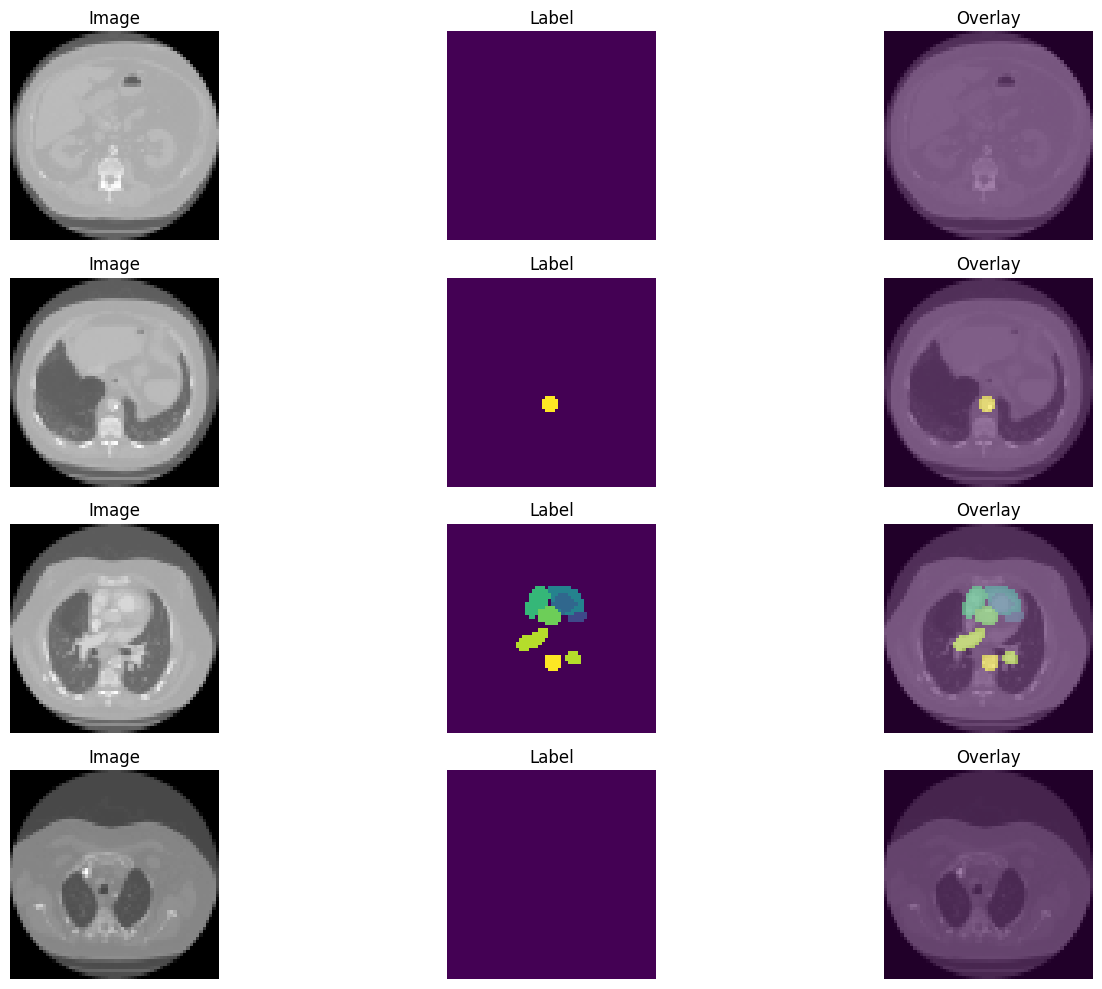

In [7]:
# Load the image and label
img = nib.load(os.path.join(image_dir, images[0]))
label = nib.load(os.path.join(image_dir, labels[0]))

# Get image and label data
img_data = img.get_fdata()
label_data = label.get_fdata()

print(f"Image shape: {img_data.shape}")
print(f"Label shape: {label_data.shape}")

# Display the image and label
n = 4  # number of slices
fig, ax = plt.subplots(n, 3, figsize=(15, 10))

for i in range(n):
    # Show image slice
    ax[i, 0].imshow(img_data[:, :, i* img_data.shape[2]//n].T, cmap='gray')
    ax[i, 0].set_title('Image')
    ax[i, 0].axis('off')

    # Show label slice
    ax[i, 1].imshow(label_data[:, :, i* label_data.shape[2]//n].T, cmap='viridis')
    ax[i, 1].set_title('Label')
    ax[i, 1].axis('off')

    # Overlay label on image
    ax[i, 2].imshow(img_data[:, :, i* img_data.shape[2]//n].T, cmap='gray')
    ax[i, 2].imshow(label_data[:, :, i* label_data.shape[2]//n].T, cmap='viridis', alpha=0.5)
    ax[i, 2].set_title('Overlay')
    ax[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Split dataset into training, validation and testing



In [8]:
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(images, labels)]
train_files, val_files, test_files = data_dicts[:10], data_dicts[10:15], data_dicts[15:]  # Split into training and validation sets

# Display the number of training and validation samples
print(f"Training set: {len(train_files)} samples")
print(f"Validation set: {len(val_files)} samples")
print(f"Test set: {len(test_files)} samples")

Training set: 10 samples
Validation set: 5 samples
Test set: 6 samples


## Create a data loader
This will handles loading the data and doing any data augmentations for each iteration

In [9]:
# for derministic training
random_seed = 42
monai.utils.set_determinism(seed=random_seed)

# Define transformations for data augmentation and preprocessing
train_transforms = Compose([
    LoadImageD(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    SpacingD(keys=["image", "label"], pixdim=(5, 5, 5), mode=("bilinear", "nearest")),
    ScaleIntensityRangeD(keys=["image"],
                    a_min=-1000, a_max=1500, b_min=0.0, b_max=1.0, clip=True),
    SpatialPadD(keys=["image", "label"], spatial_size=(64,64,64)),
    RandCropByPosNegLabelD(keys=["image", "label"], label_key="label", spatial_size=(64,64,64), pos=1, neg=1, num_samples=2),
    RandFlipD(keys=["image", "label"], prob=0.5, spatial_axis=[0]),
    RandShiftIntensityD(keys="image", offsets=0.1, prob=0.5),
    RandRotate90D(keys=["image", "label"], prob=0.5, max_k=3),
    AsDiscreteD(keys=["label"], to_onehot=10),
    EnsureTypeD(keys=["image", "label"])
])

val_transforms = Compose([
    LoadImageD(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    SpacingD(keys=["image", "label"], pixdim=(5, 5, 5), mode=("bilinear", "nearest")),
    ScaleIntensityRangeD(keys=["image"],
                    a_min=-1000, a_max=1500, b_min=0.0, b_max=1.0, clip=True),
    AsDiscreteD(keys=["label"], to_onehot=10),
    EnsureTypeD(keys=["image", "label"])
])

# Create datasets and dataloaders
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1)

test_ds = CacheDataset(data=test_files, transform=val_transforms, cache_rate=1.0)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 6/6 [00:00<00:00, 24.50it/s]


## Define our ML model, loss function and evaluation metric

In [10]:
# Define the 3D U-Net model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=10,  # Background plus our 9 classes
    channels=(16, 32, 64, 128),  # Feature map channels
    strides=(2, 2, 2),  # Downsample with strides
    num_res_units=2,  # Residual units
    norm=Norm.BATCH,  # Use batch normalization
).to(device)

# Define loss function and optimizer
loss_function = DiceCELoss(softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define evaluation metrics
dice_metric = DiceMetric(include_background=False, reduction="mean", num_classes=10)

## Run our training loop

----------
epoch 1/750
1/1 loss: 3.3883
epoch 1 average loss: 3.3883
----------
epoch 2/750
1/1 loss: 3.3620
epoch 2 average loss: 3.3620
----------
epoch 3/750
1/1 loss: 3.3366
epoch 3 average loss: 3.3366
----------
epoch 4/750
1/1 loss: 3.3098
epoch 4 average loss: 3.3098
----------
epoch 5/750
1/1 loss: 3.2863
epoch 5 average loss: 3.2863
----------
epoch 6/750
1/1 loss: 3.2609
epoch 6 average loss: 3.2609
----------
epoch 7/750
1/1 loss: 3.2376
epoch 7 average loss: 3.2376
----------
epoch 8/750
1/1 loss: 3.2115
epoch 8 average loss: 3.2115
----------
epoch 9/750
1/1 loss: 3.1899
epoch 9 average loss: 3.1899
----------
epoch 10/750
1/1 loss: 3.1667
epoch 10 average loss: 3.1667
----------
epoch 11/750
1/1 loss: 3.1455
epoch 11 average loss: 3.1455
----------
epoch 12/750
1/1 loss: 3.1235
epoch 12 average loss: 3.1235
----------
epoch 13/750
1/1 loss: 3.1036
epoch 13 average loss: 3.1036
----------
epoch 14/750
1/1 loss: 3.0820
epoch 14 average loss: 3.0820
----------
epoch 15/750


/tmp/ipykernel_1061631/4280961892.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(n, 3, figsize=(15, 10))


----------
epoch 551/750
1/1 loss: 0.7196
epoch 551 average loss: 0.7196
----------
epoch 552/750
1/1 loss: 0.7121
epoch 552 average loss: 0.7121
----------
epoch 553/750
1/1 loss: 0.7070
epoch 553 average loss: 0.7070
----------
epoch 554/750
1/1 loss: 0.7054
epoch 554 average loss: 0.7054
----------
epoch 555/750
1/1 loss: 0.7064
epoch 555 average loss: 0.7064
----------
epoch 556/750
1/1 loss: 0.7046
epoch 556 average loss: 0.7046
----------
epoch 557/750
1/1 loss: 0.7021
epoch 557 average loss: 0.7021
----------
epoch 558/750
1/1 loss: 0.7028
epoch 558 average loss: 0.7028
----------
epoch 559/750
1/1 loss: 0.6973
epoch 559 average loss: 0.6973
----------
epoch 560/750
1/1 loss: 0.6954
epoch 560 average loss: 0.6954
----------
epoch 561/750
1/1 loss: 0.6940
epoch 561 average loss: 0.6940
----------
epoch 562/750
1/1 loss: 0.6889
epoch 562 average loss: 0.6889
----------
epoch 563/750
1/1 loss: 0.6858
epoch 563 average loss: 0.6858
----------
epoch 564/750
1/1 loss: 0.6823
epoch 564

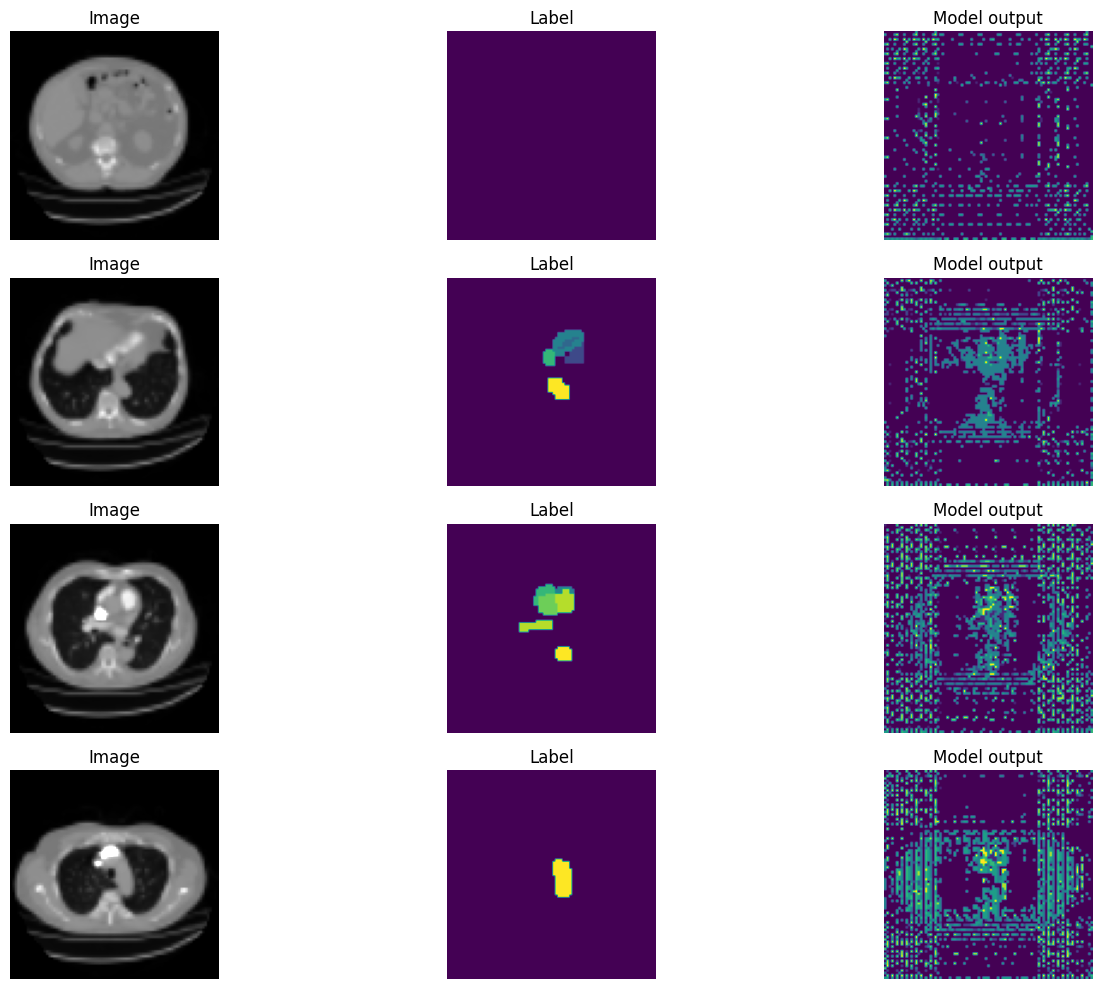

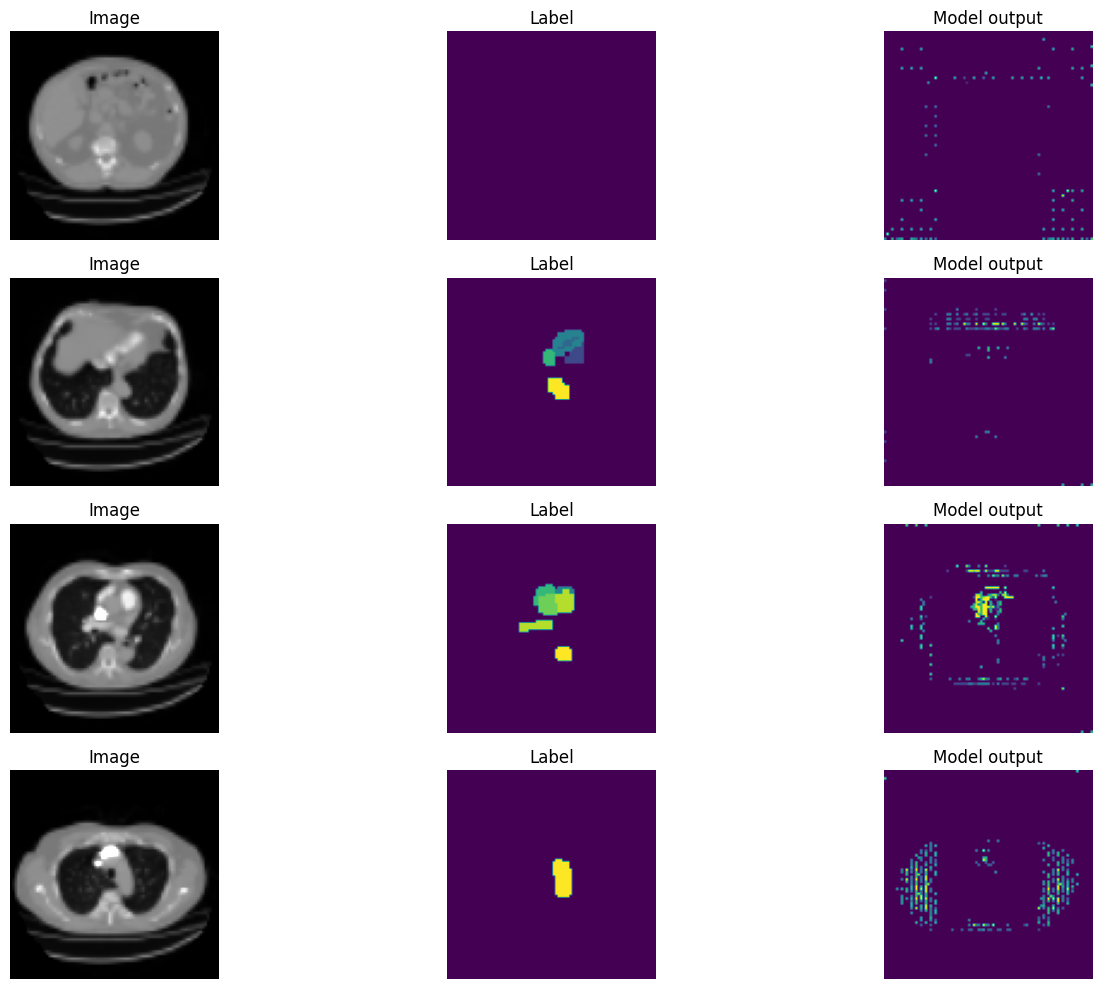

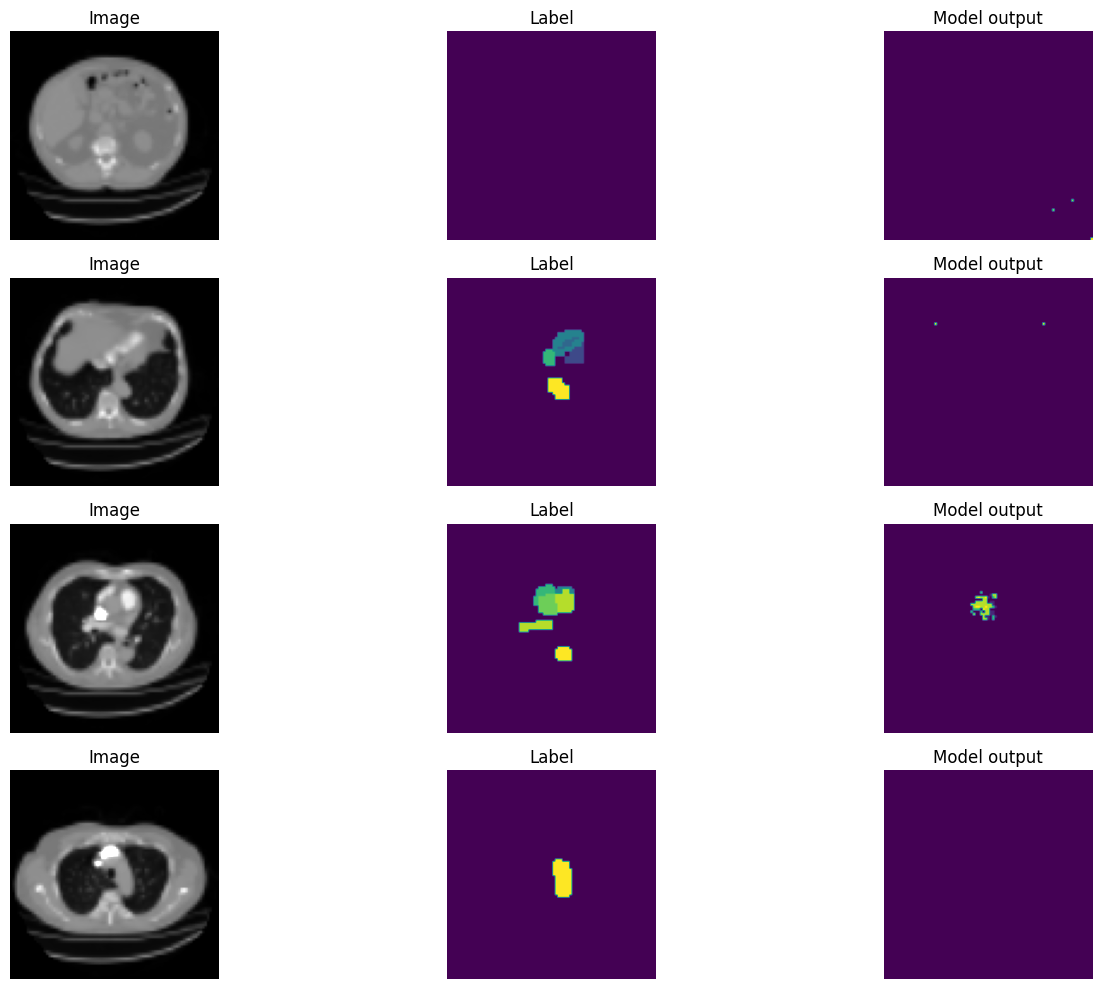

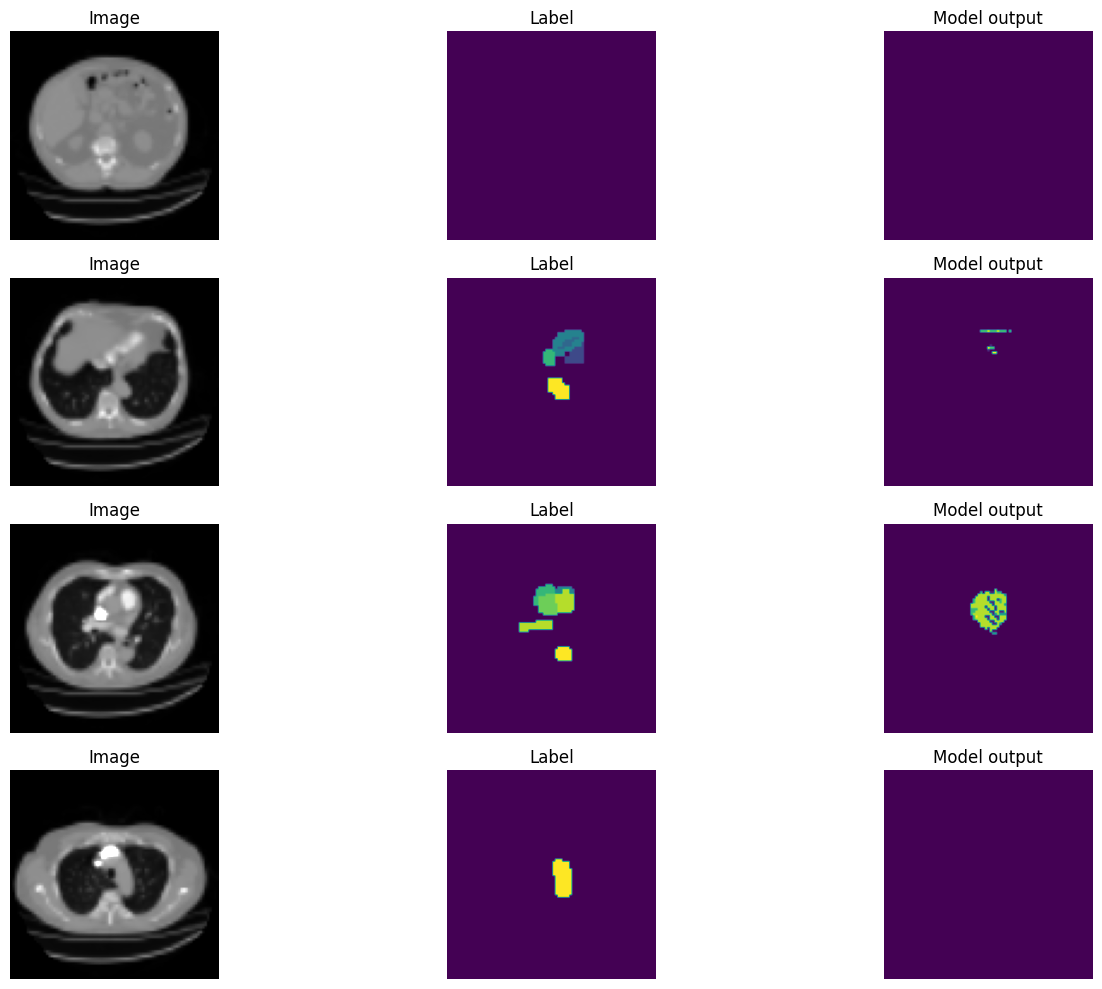

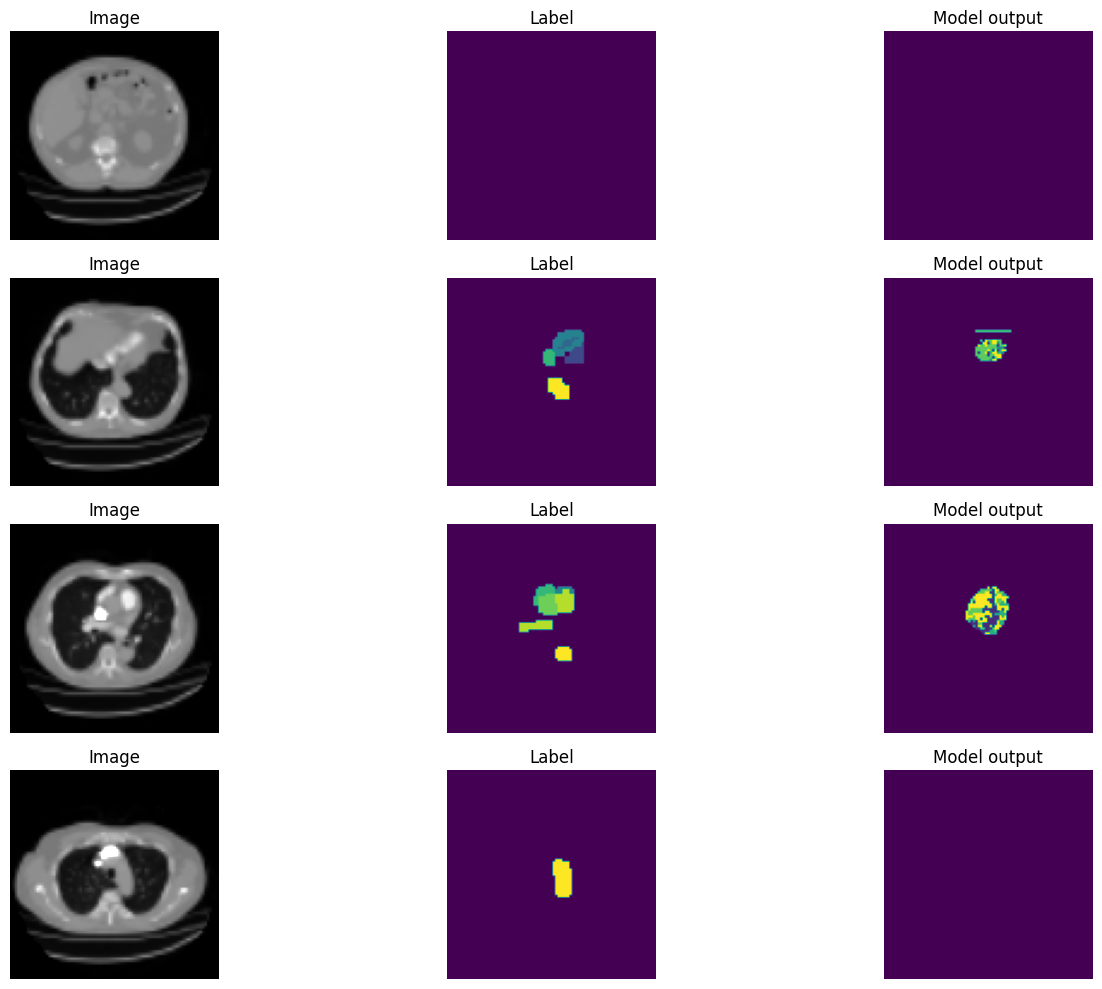

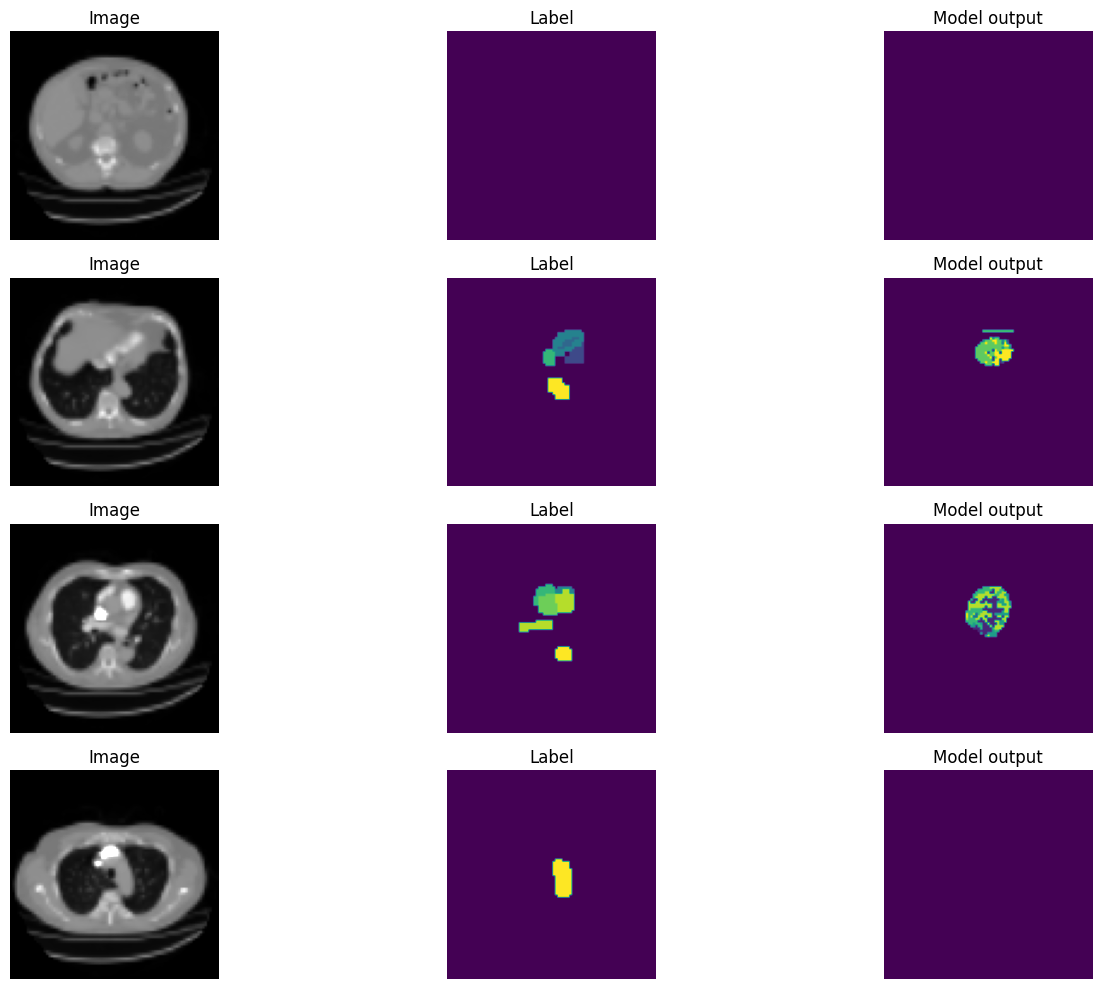

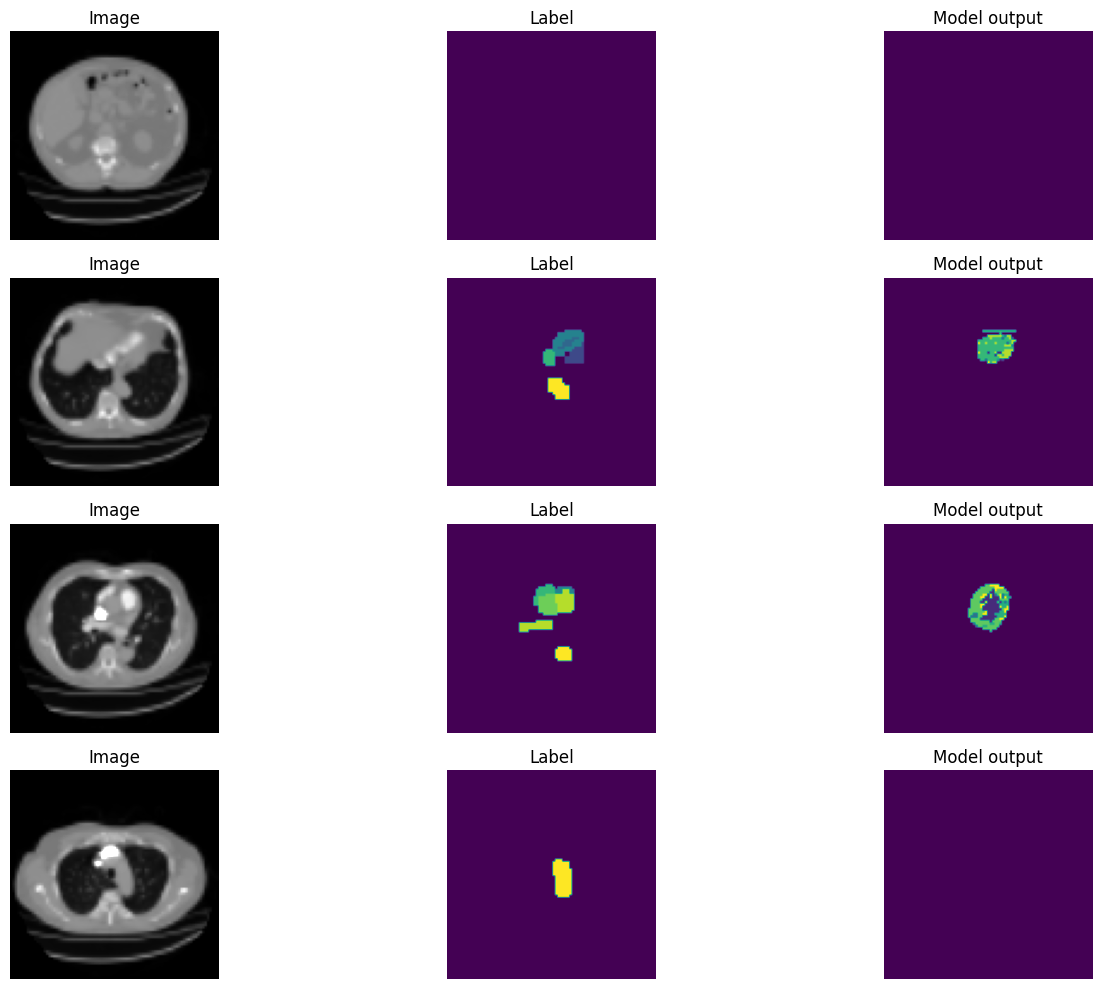

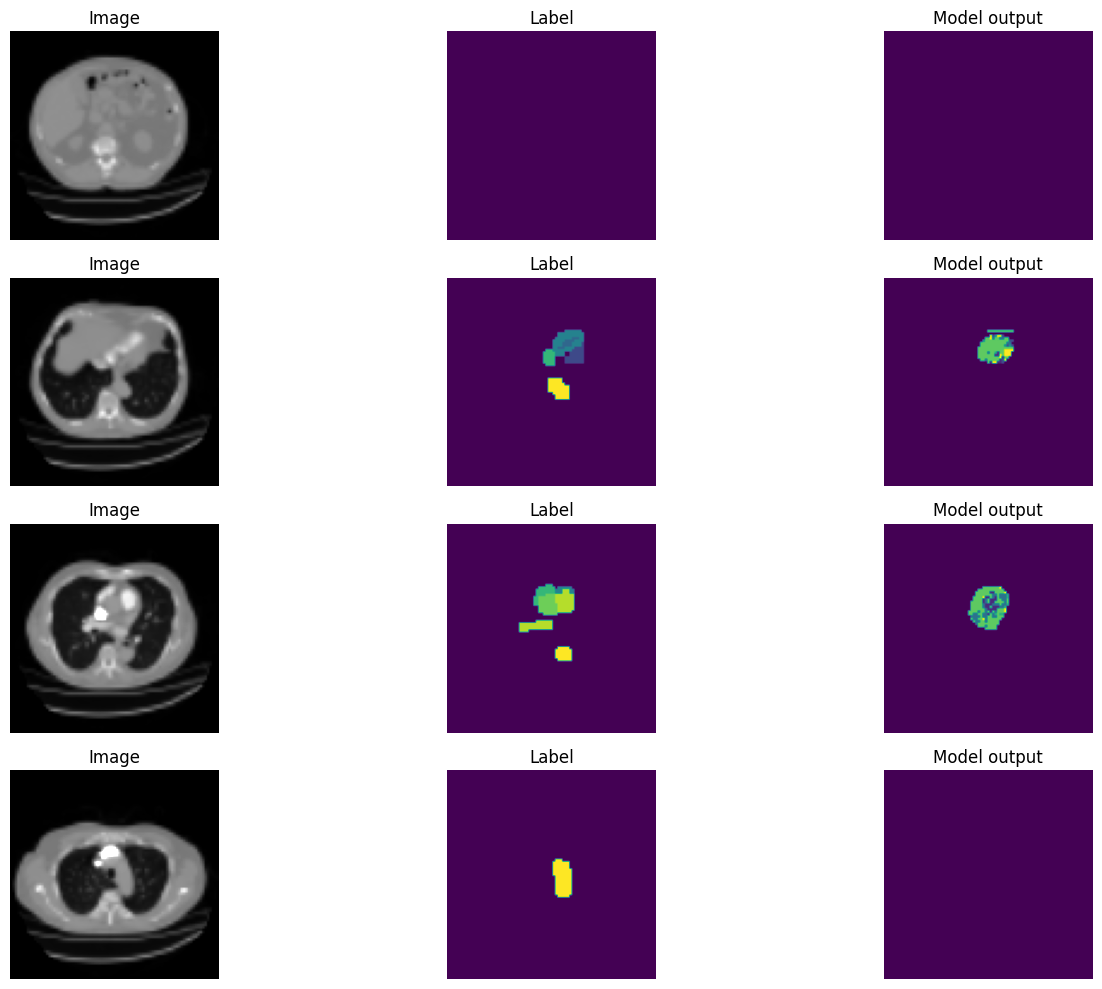

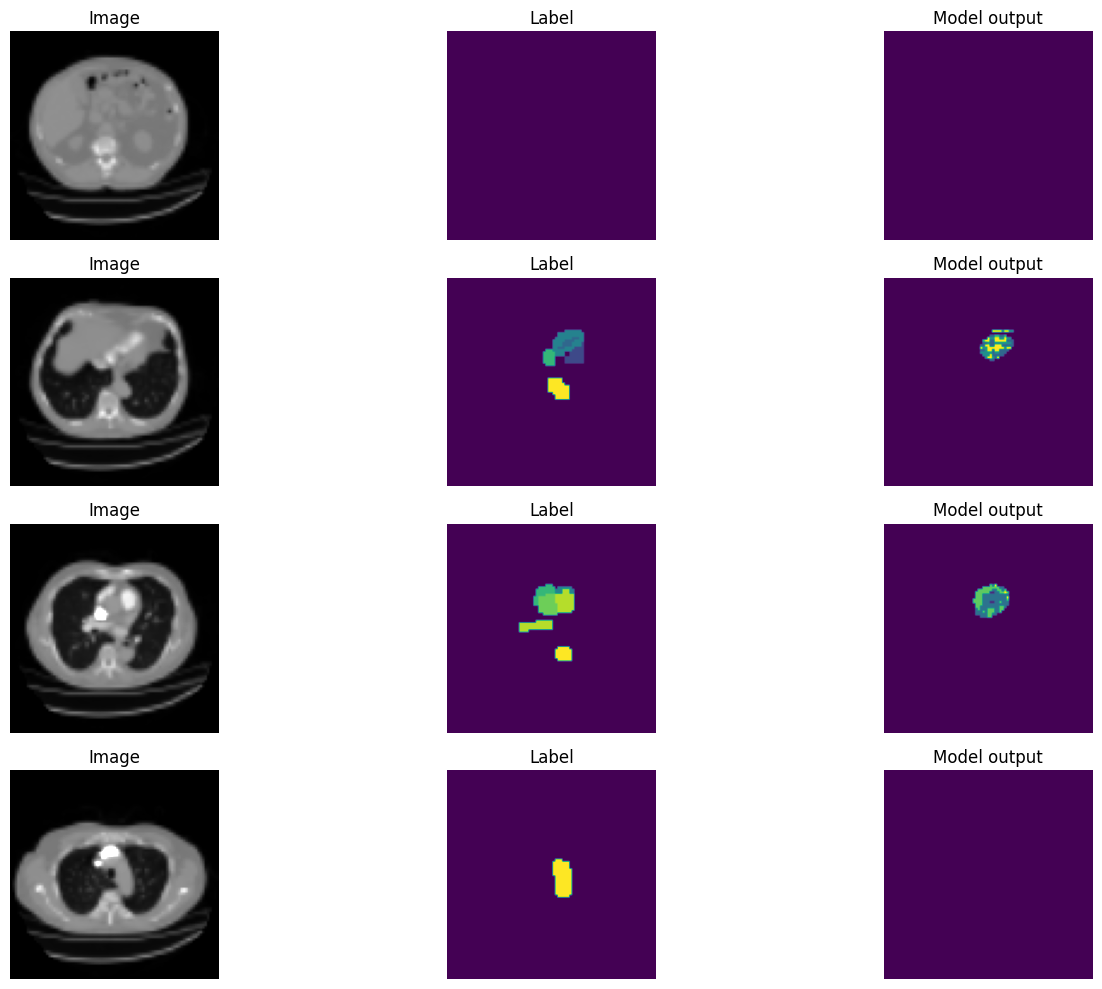

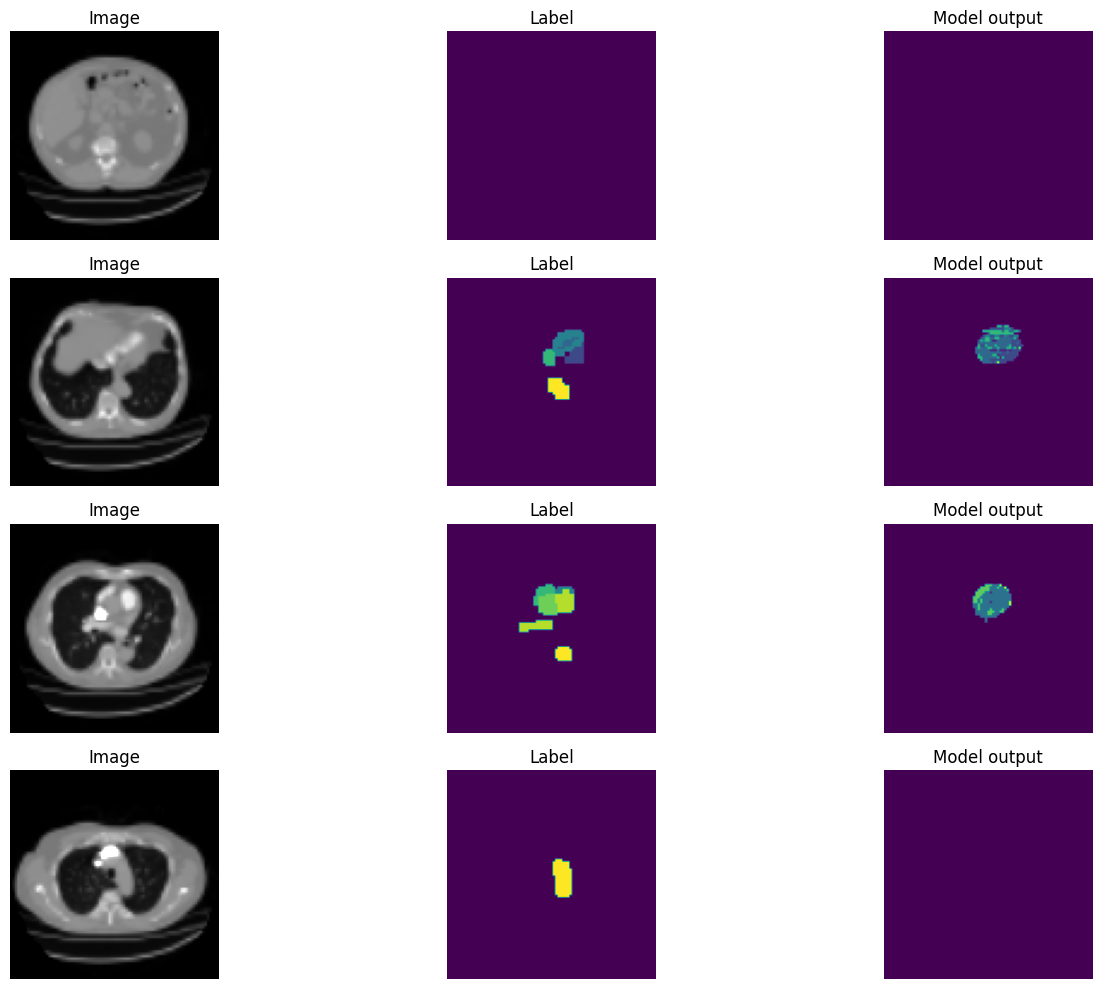

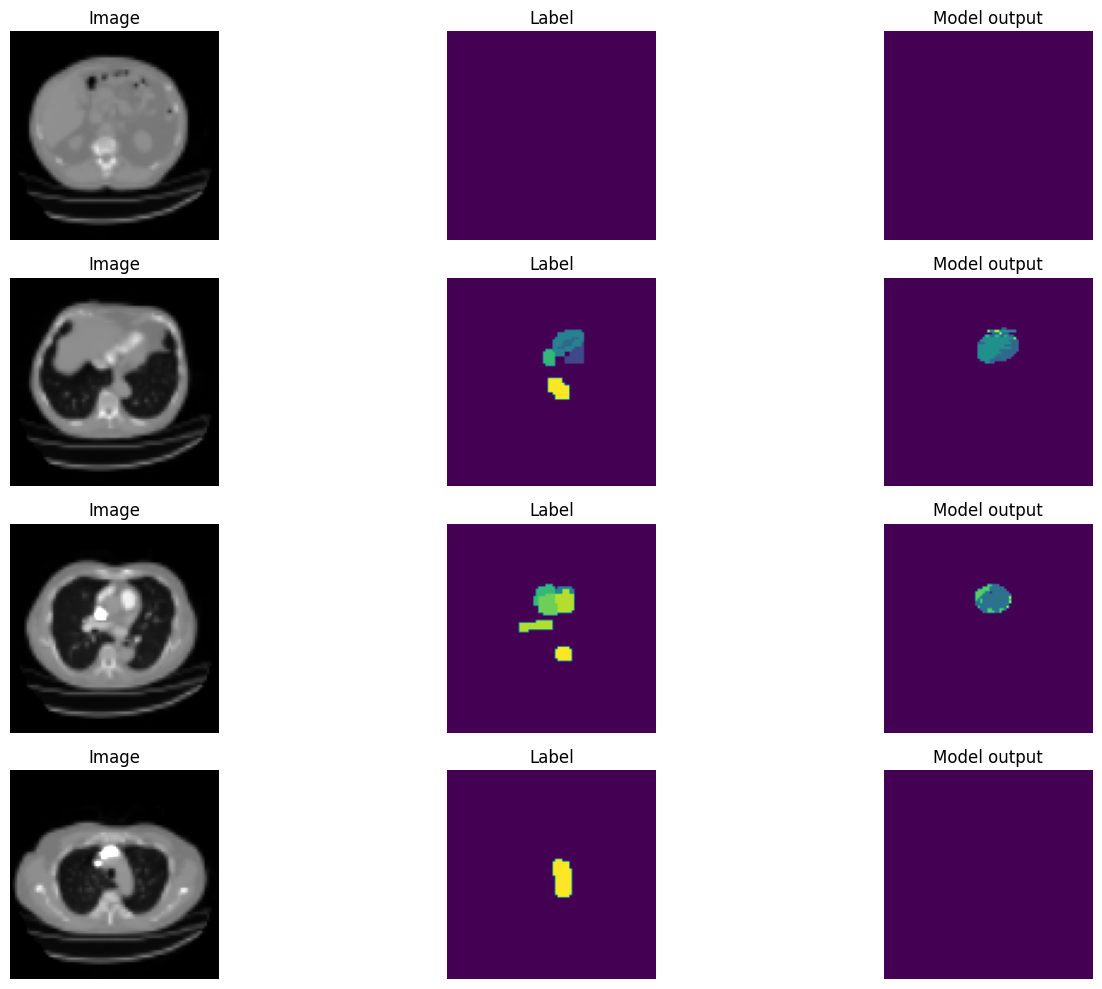

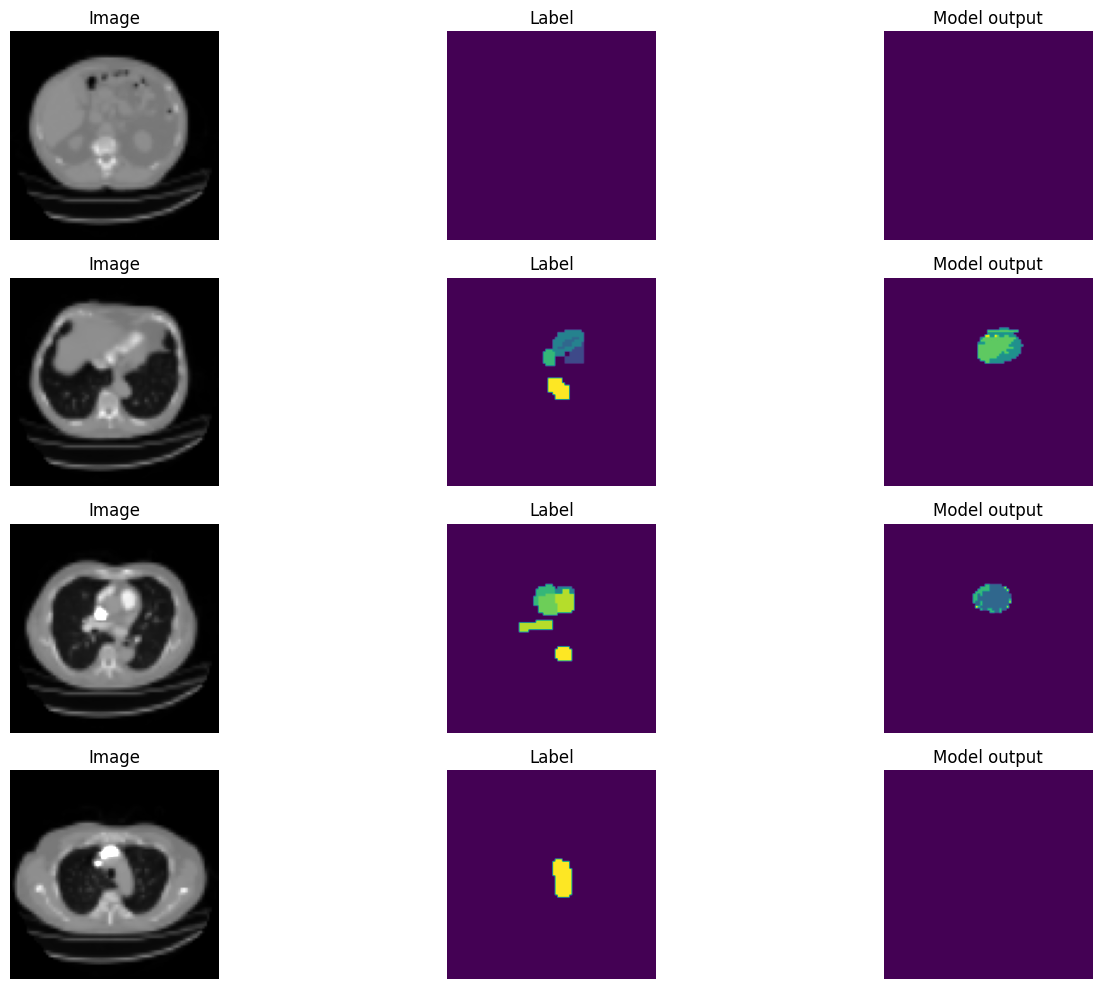

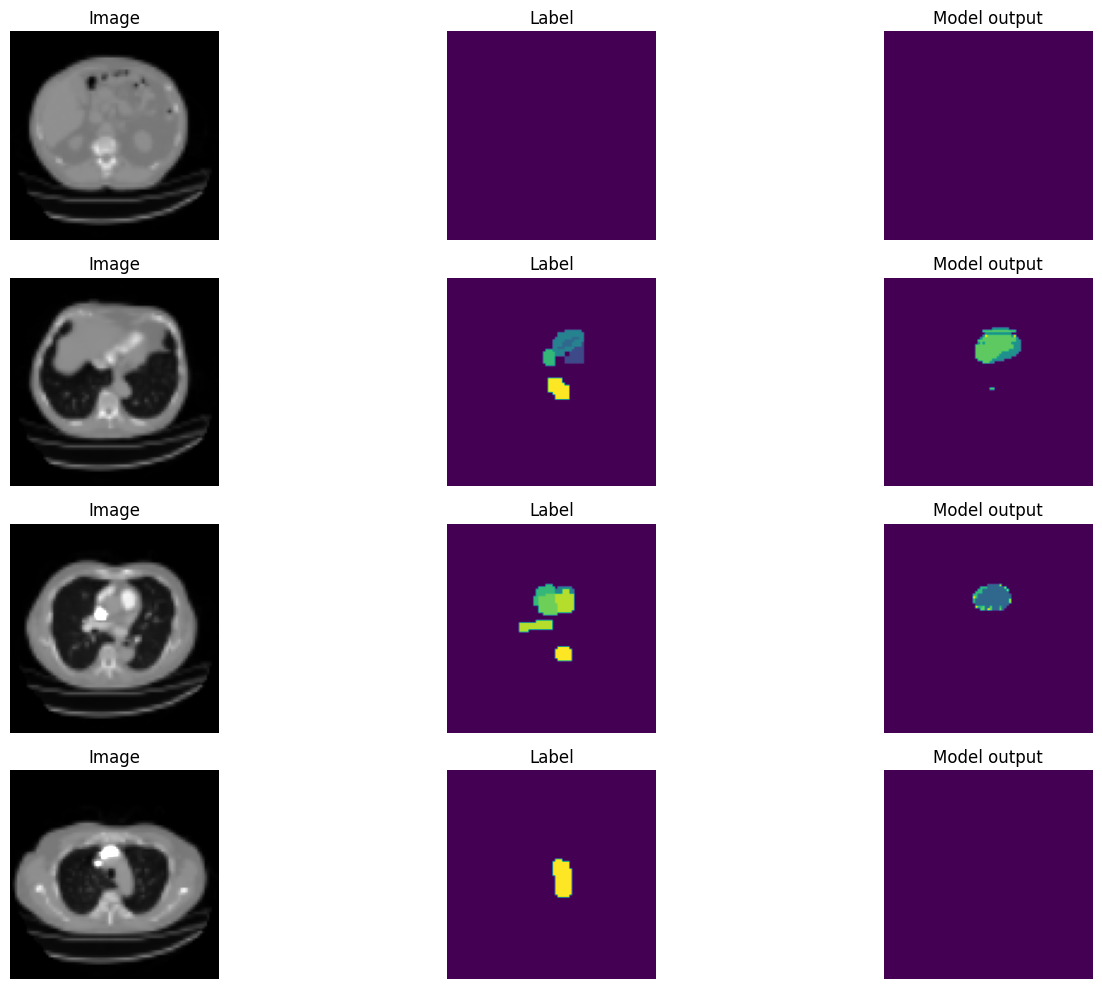

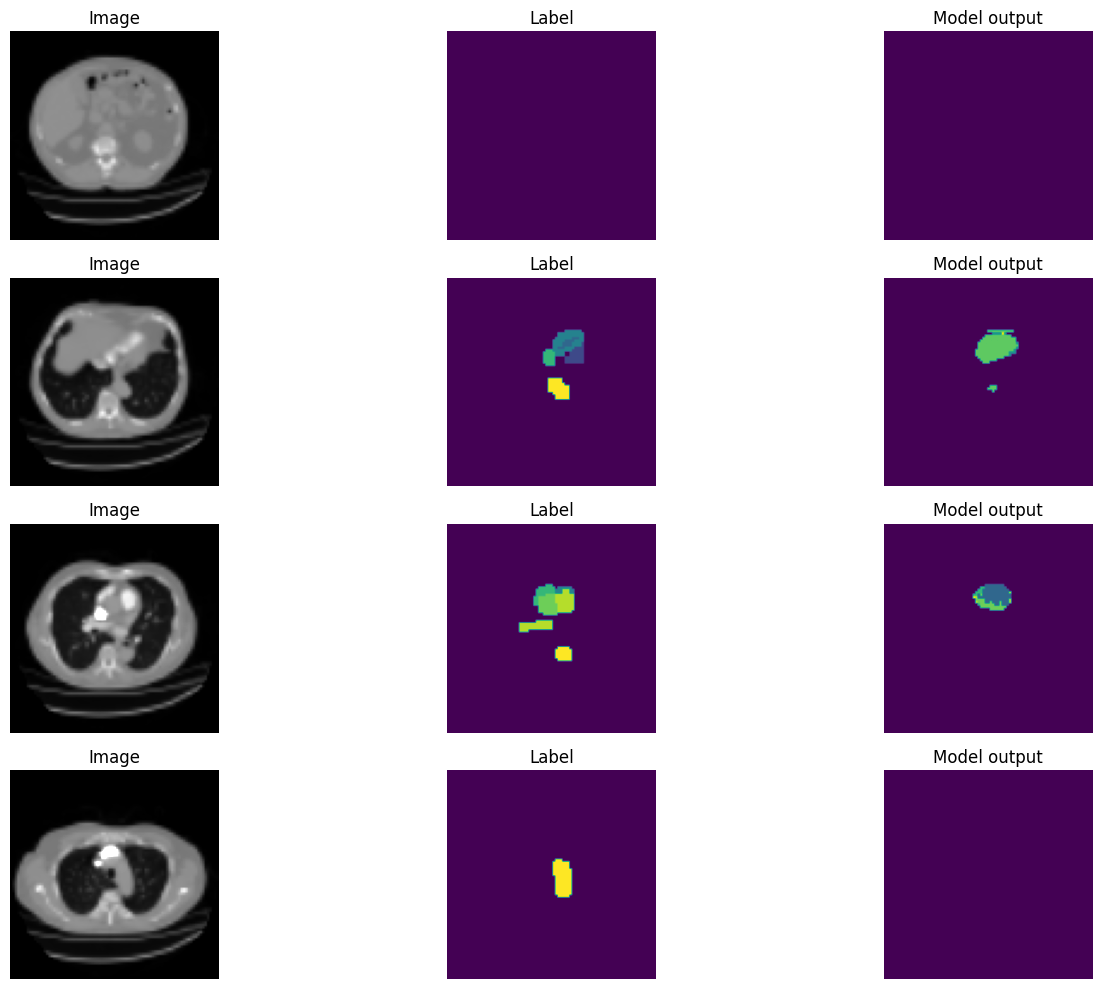

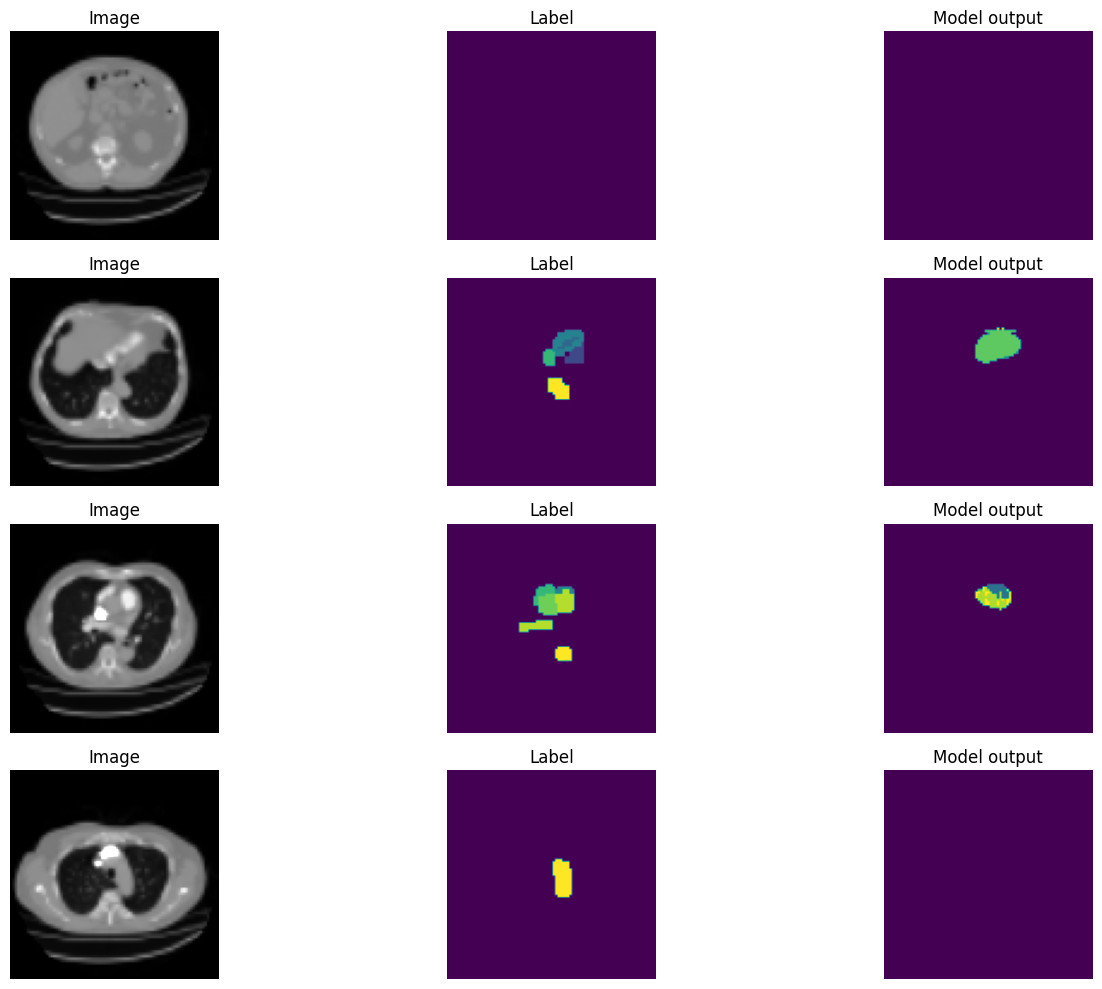

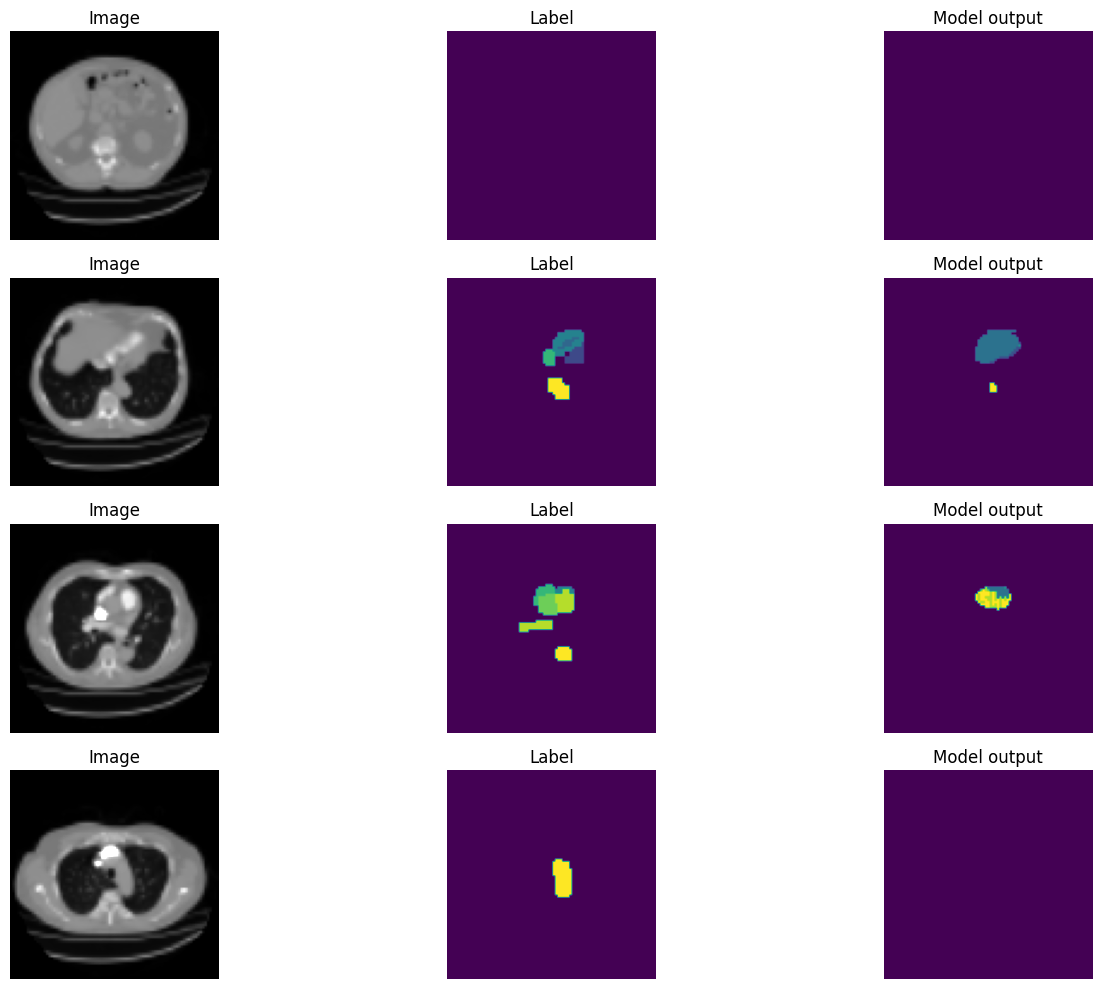

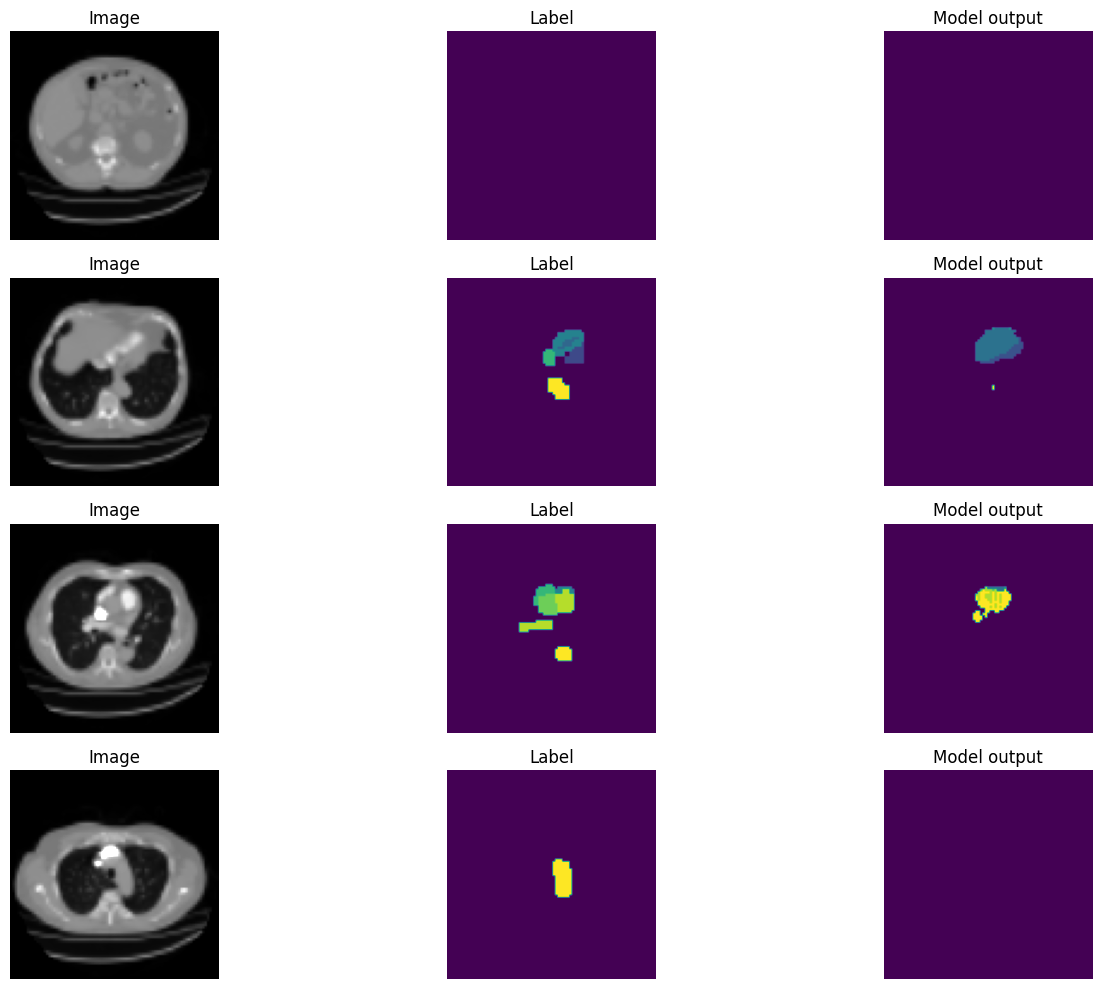

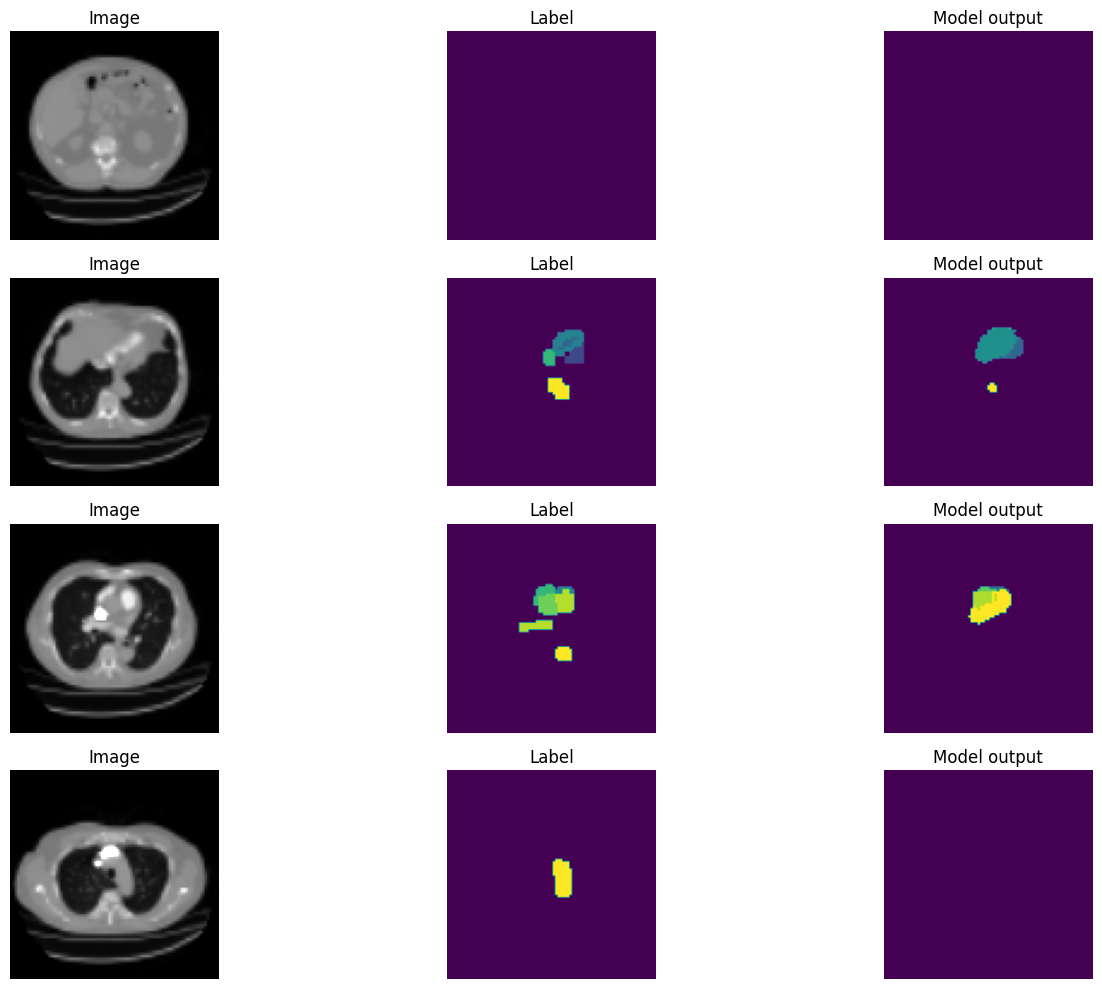

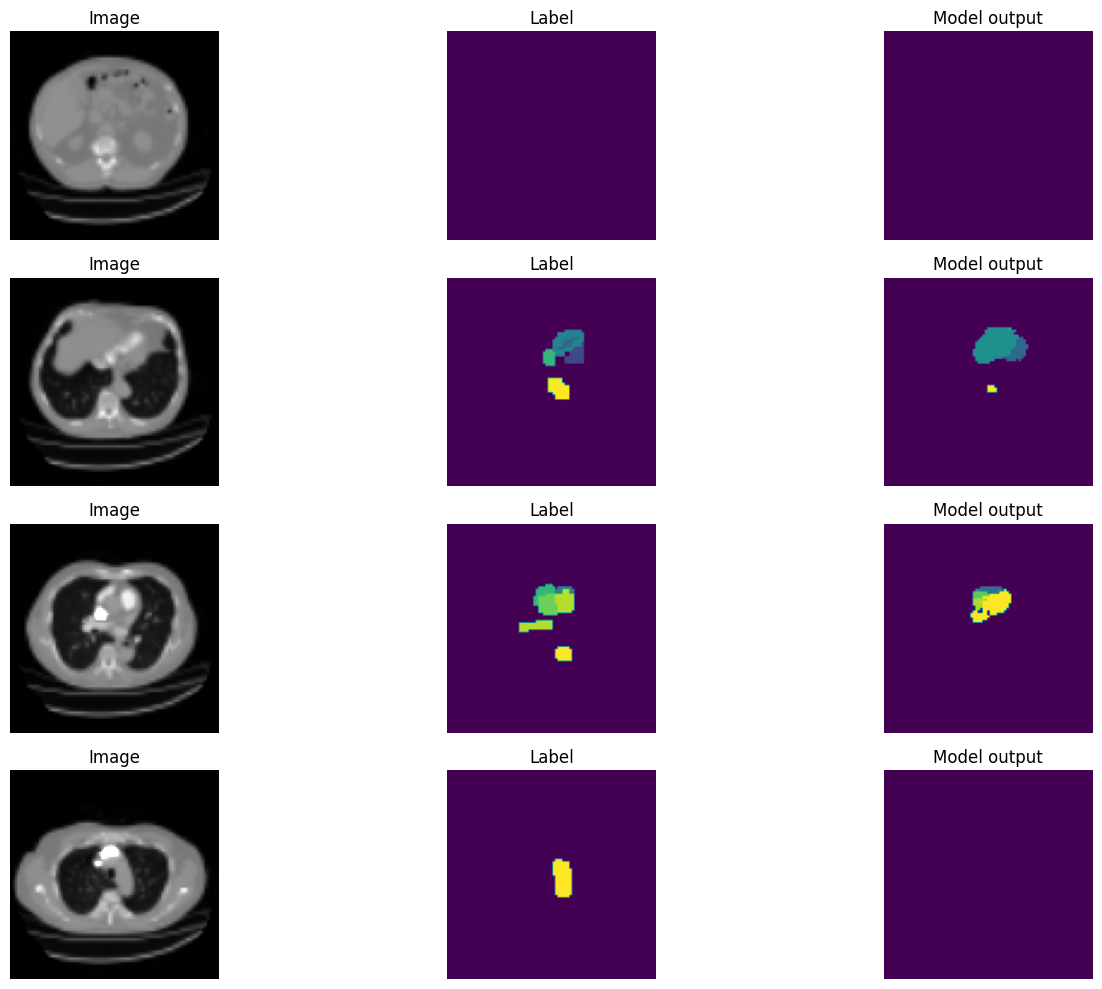

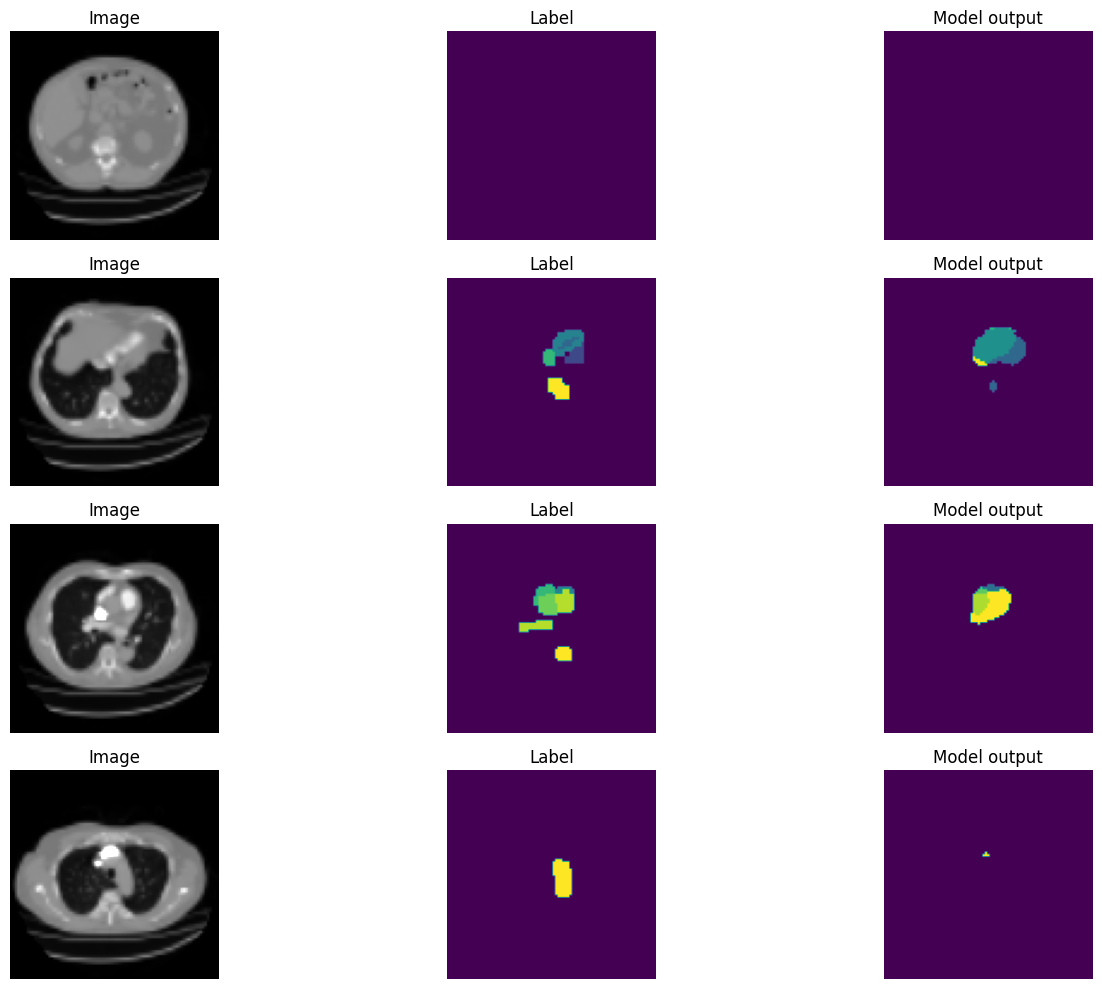

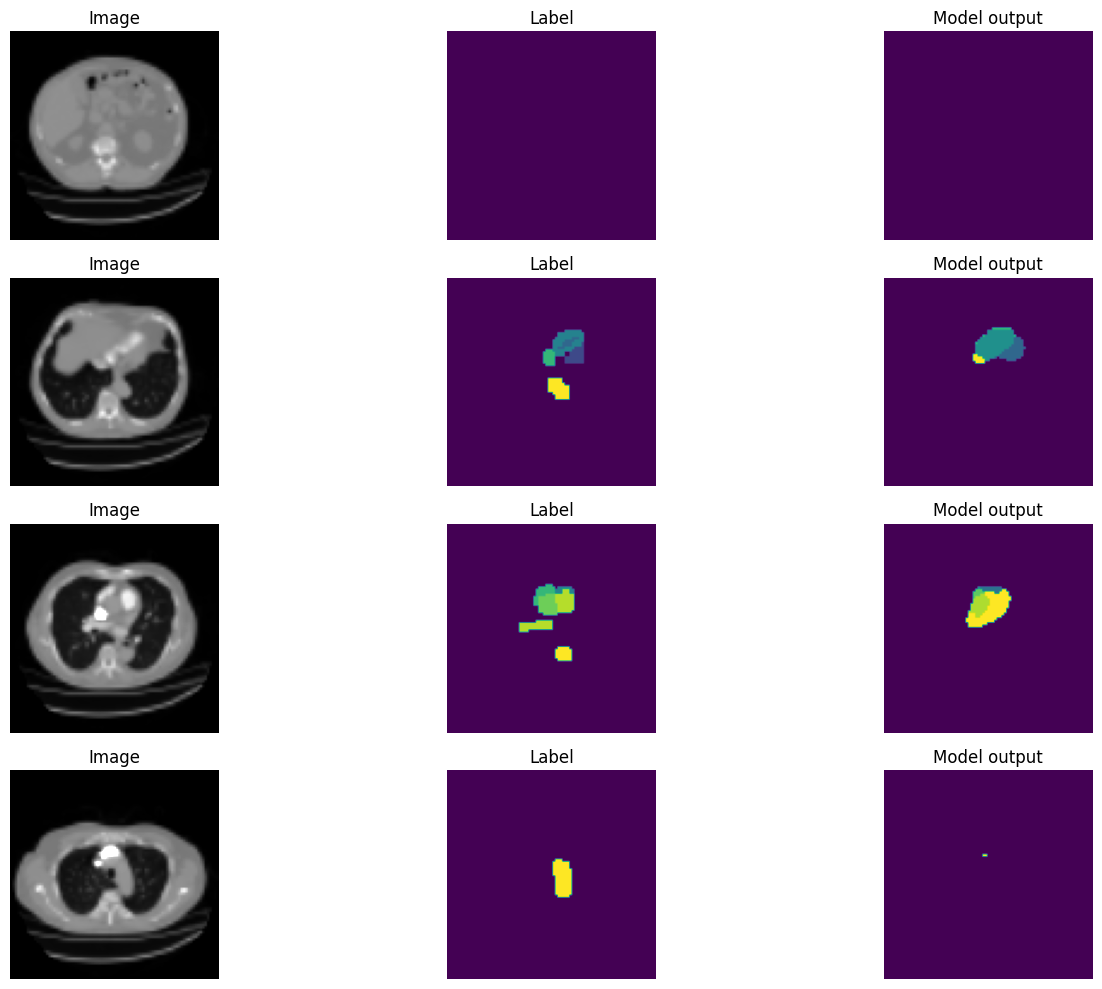

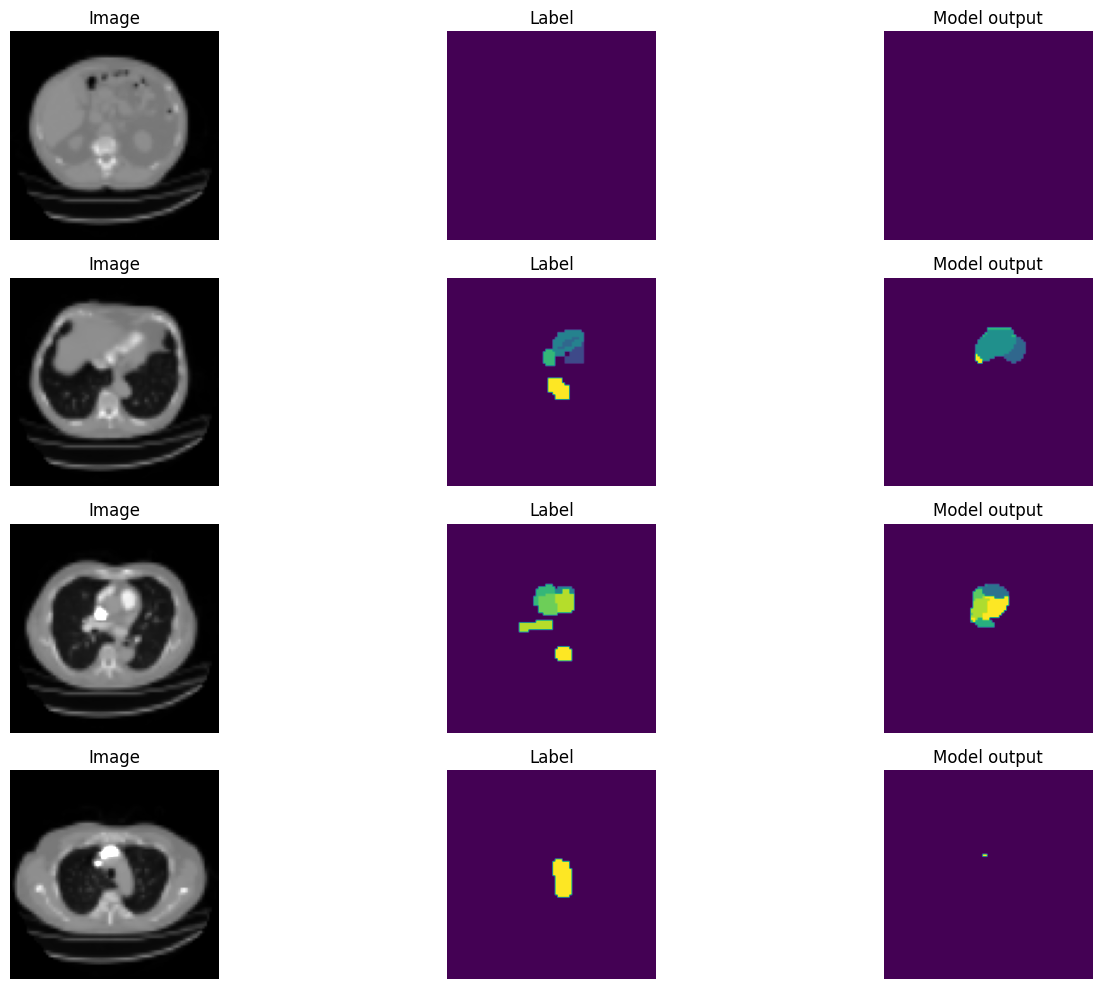

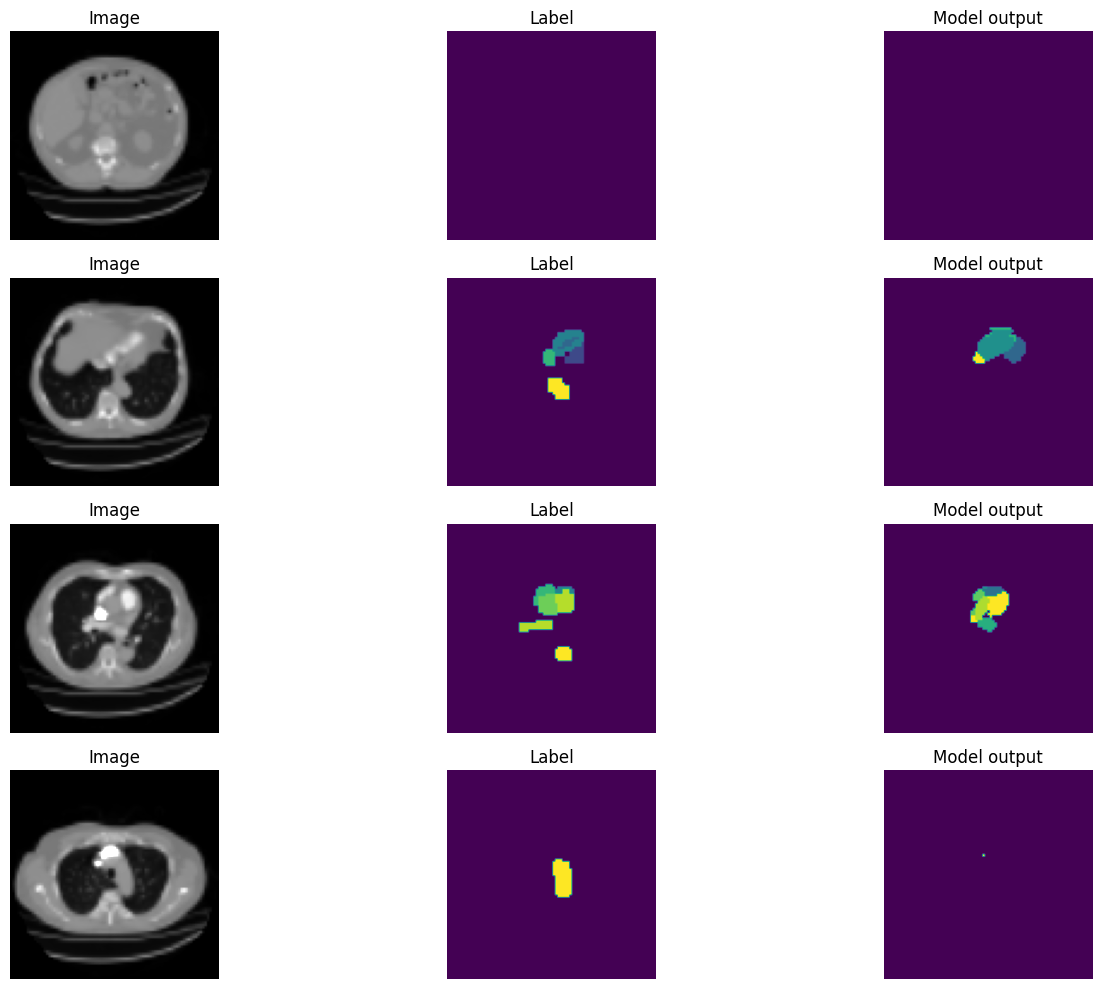

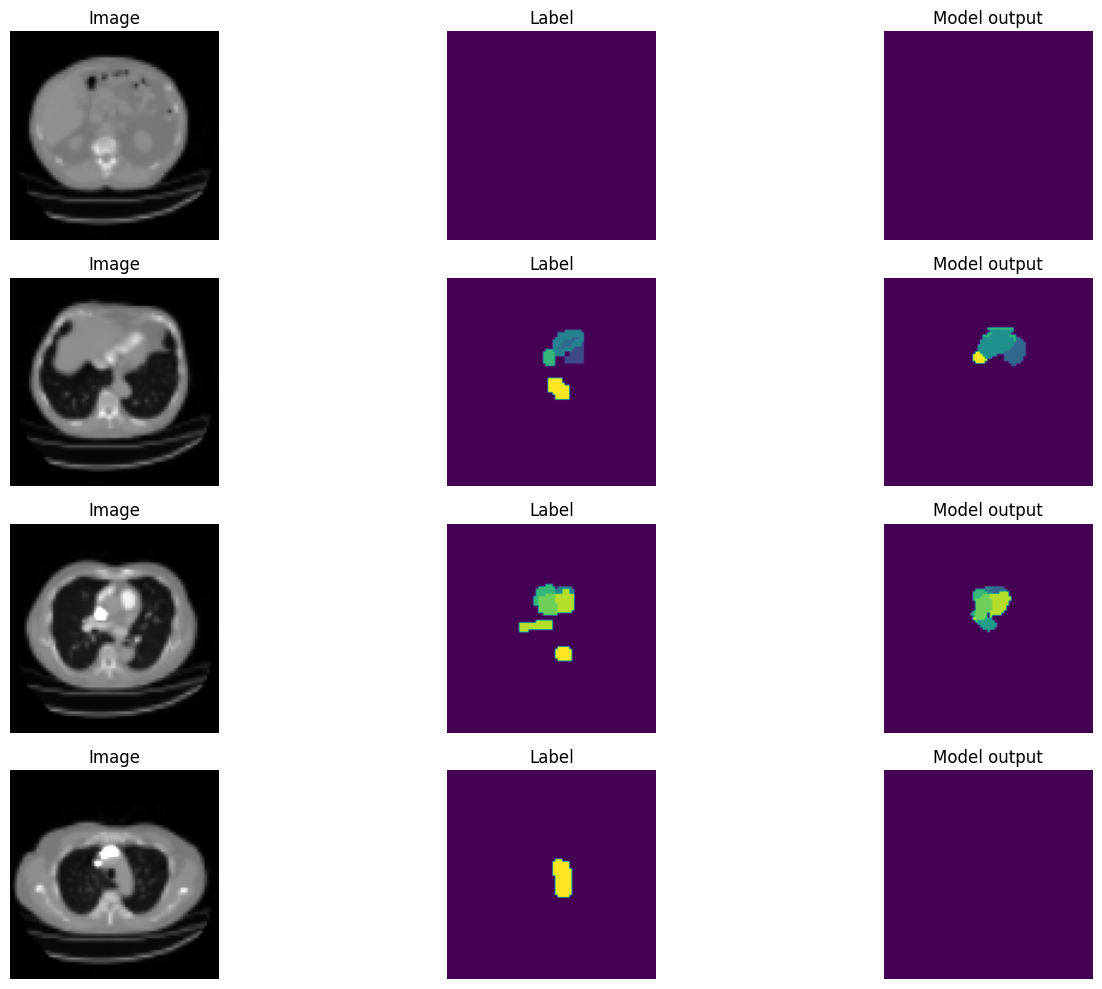

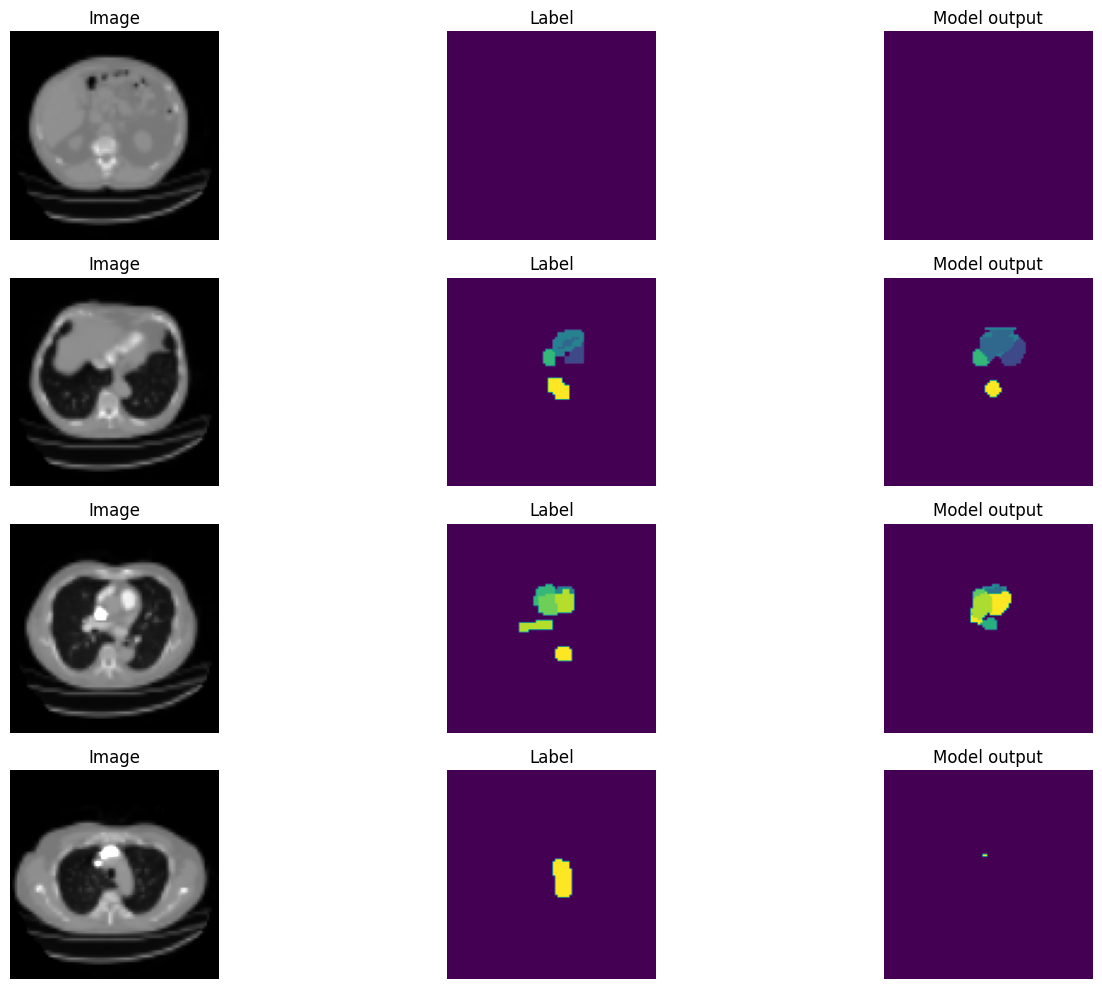

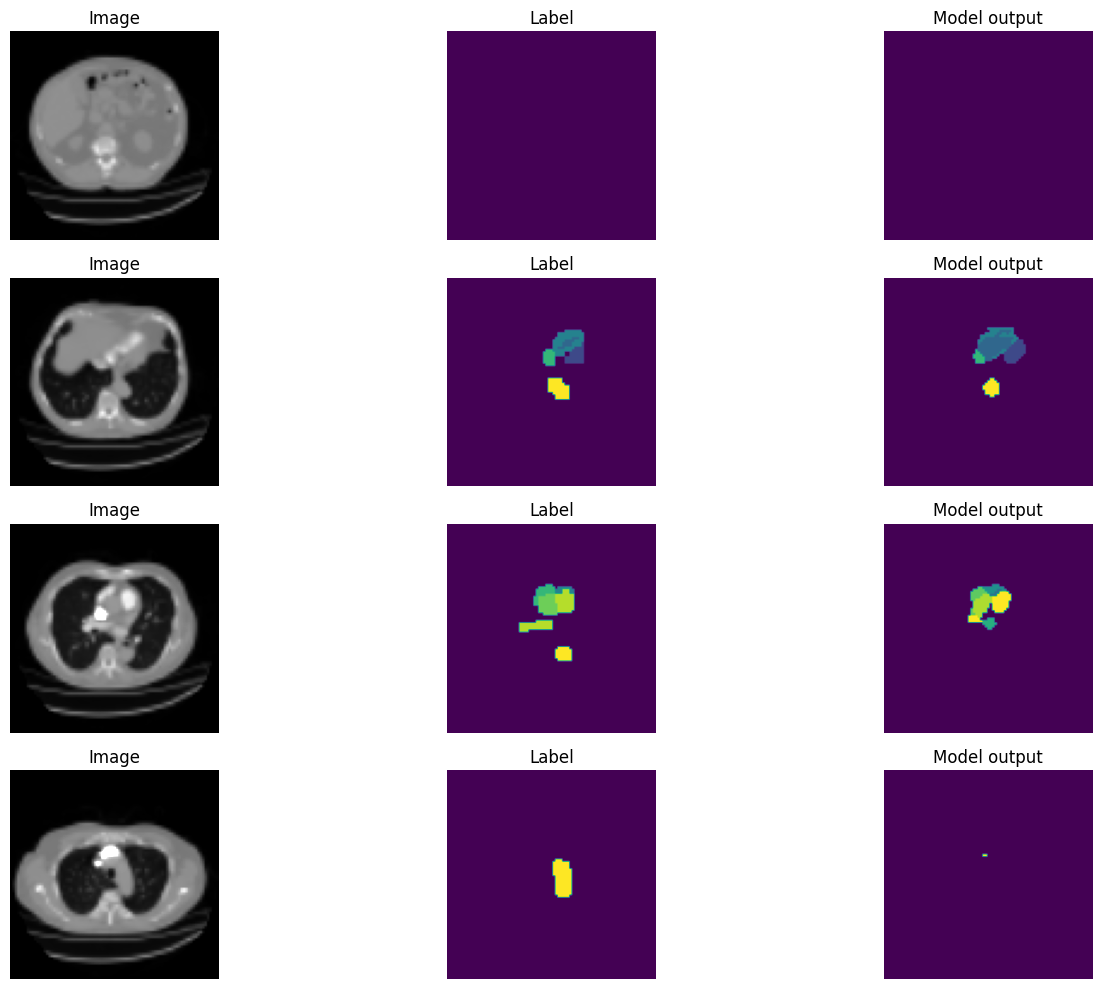

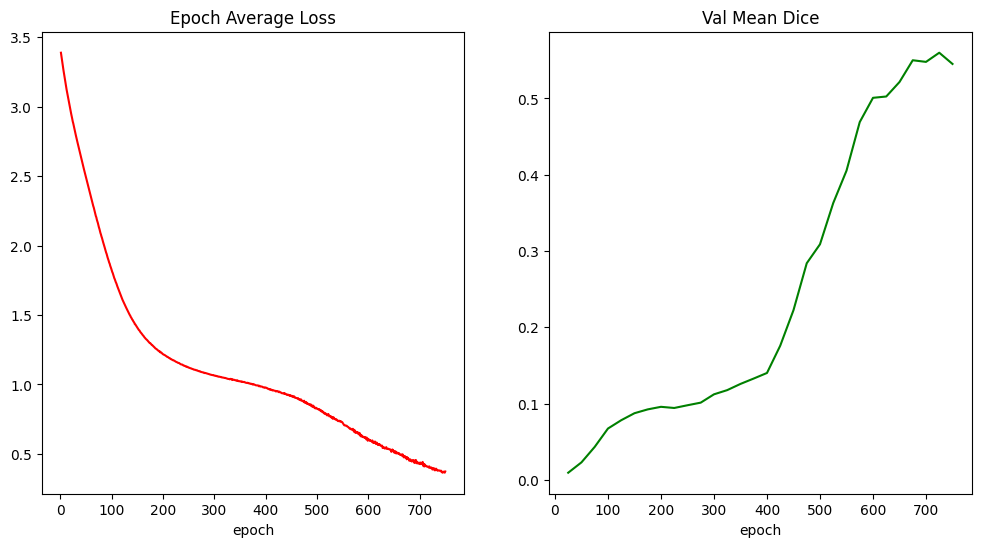

In [11]:
# Training loop
max_epochs = 750 # Train for 100 epochs
val_interval = 25  # Evaluate the model every 5 epochs
best_metric = -1
best_metric_epoch = -1
metric_values = []
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_loader)} loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_dice = 0
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                # here we need to do a sliding window inference on the entire image
                val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.25)
                val_outputs = torch.softmax(val_outputs, 1)  # Apply softmax
                val_outputs = torch.argmax(val_outputs, dim=1, keepdim=True)  # Get class predictions
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            print(f"epoch {epoch + 1} validation mean dice: {metric:.4f}")
            
            # Save best model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("Saved new best metric model")

                # Let's save the first validation image, label, and model output
                val_data = first(val_loader)
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.25)
                val_outputs = torch.softmax(val_outputs, 1)  # Apply softmax
                val_outputs = torch.argmax(val_outputs, dim=1, keepdim=True)  # Get class predictions
                # Convert output and label to numpy arrays and undo one-hot encoding
                val_outputs = val_outputs.detach().cpu().numpy().squeeze()
                val_labels = val_labels.detach().cpu().numpy().squeeze()
                val_inputs = val_inputs.detach().cpu().numpy().squeeze()
                val_labels = np.argmax(val_labels, axis=0)
                # Display the slices
                n = 4  # number of slices
                fig, ax = plt.subplots(n, 3, figsize=(15, 10))
                for i in range(n):
                    # Show image slice
                    ax[i, 0].imshow(val_inputs[:, :, i* val_inputs.shape[2]//n].T, vmin=0.0, vmax=0.75, cmap='gray')
                    ax[i, 0].set_title('Image')
                    ax[i, 0].axis('off')
                    # Show label slice
                    ax[i, 1].imshow(val_labels[:, :, i* val_labels.shape[2]//n].T, cmap='viridis')
                    ax[i, 1].set_title('Label')
                    ax[i, 1].axis('off')
                    # Show model output slice
                    ax[i, 2].imshow(val_outputs[:, :, i* val_outputs.shape[2]//n].T, cmap='viridis')
                    ax[i, 2].set_title('Model output')
                    ax[i, 2].axis('off')
                # save the figure
                plt.tight_layout()
                plt.savefig(f"val_output_{epoch+1}.png", dpi=300, bbox_inches='tight')
                
print(f"Training completed. Best validation mean dice: {best_metric:.4f} at epoch {best_metric_epoch}")

# Plot the loss and metric
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color='red')
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color='green')
plt.savefig("loss_metric.png", dpi=300, bbox_inches='tight')

## Load our best model and evaluate performance in the test set

Test mean dice: 0.5788


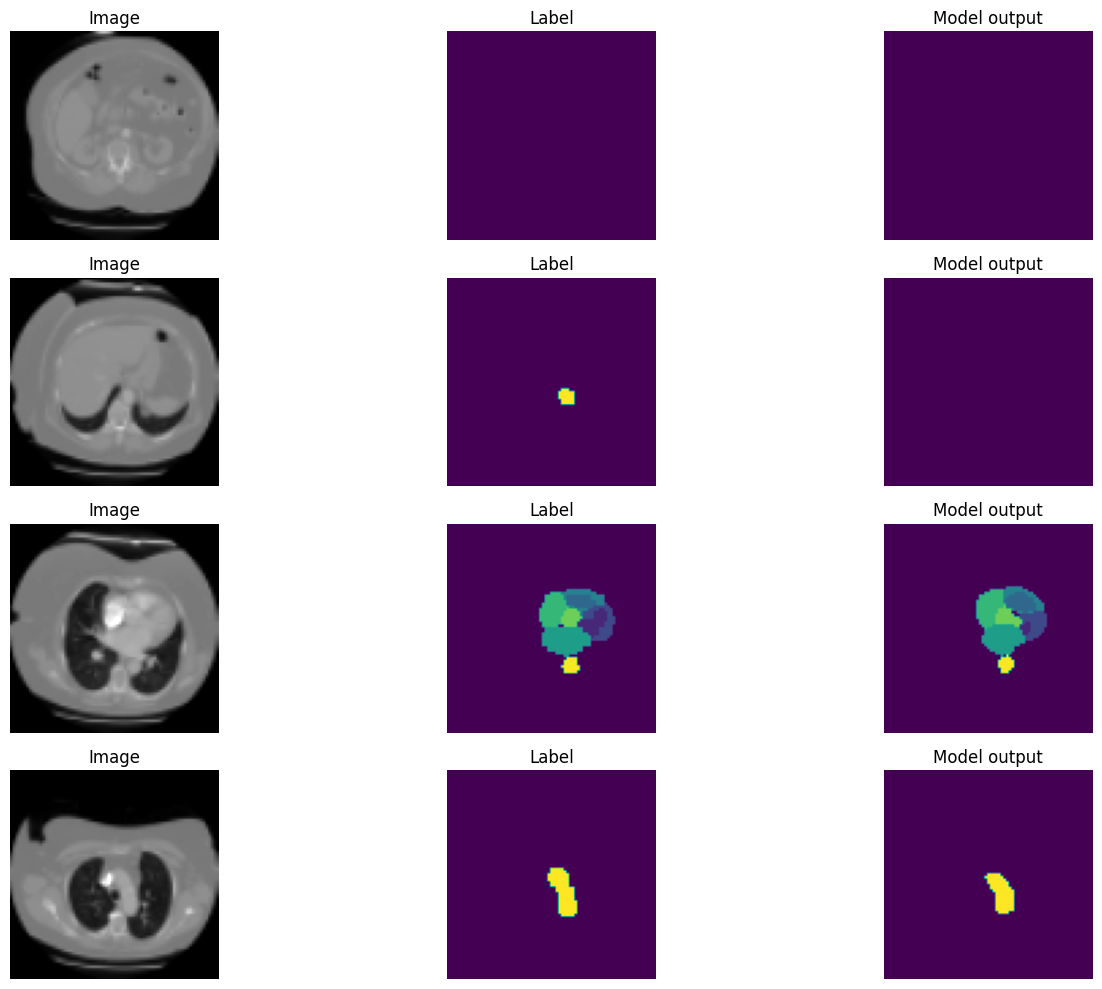

In [13]:
# Load the best model and test

model.load_state_dict(torch.load("best_metric_model.pth", weights_only=True))
model.eval()
model.to(device)
with torch.no_grad():
    test_dice = 0
    for test_data in test_loader:
        test_inputs, test_labels = test_data["image"].to(device), test_data["label"].to(device)
        test_outputs = sliding_window_inference(test_inputs, (64, 64, 64), 4, model, overlap=0.25)
        test_outputs = torch.softmax(test_outputs, 1)  # Apply softmax
        test_outputs = torch.argmax(test_outputs, dim=1, keepdim=True)  # Get class predictions
        dice_metric(y_pred=test_outputs, y=test_labels)
    metric = dice_metric.aggregate().item()
    dice_metric.reset()
    print(f"Test mean dice: {metric:.4f}")

    # Display the first test image, label, and model output
    test_data = first(test_loader)
    test_inputs, test_labels = test_data["image"].to(device), test_data["label"].to(device)
    test_outputs = sliding_window_inference(test_inputs, (64, 64, 64), 4, model, overlap=0.25)
    test_outputs = torch.softmax(test_outputs, 1)  # Apply softmax
    test_outputs = torch.argmax(test_outputs, dim=1, keepdim=True)  # Get class predictions
    # Convert output and label to numpy arrays and undo one-hot encoding
    test_outputs = test_outputs.detach().cpu().numpy().squeeze()
    test_labels = test_labels.detach().cpu().numpy().squeeze()
    test_inputs = test_inputs.detach().cpu().numpy().squeeze()
    test_labels = np.argmax(test_labels, axis=0)
    # Display the slices
    n = 4  # number of slices
    fig, ax = plt.subplots(n, 3, figsize=(15, 10))
    for i in range(n):
        # Show image slice
        ax[i, 0].imshow(test_inputs[:, :, i* test_inputs.shape[2]//n].T, vmin=0, vmax=0.75, cmap='gray')
        ax[i, 0].set_title('Image')
        ax[i, 0].axis('off')
        # Show label slice
        ax[i, 1].imshow(test_labels[:, :, i* test_labels.shape[2]//n].T, cmap='viridis')
        ax[i, 1].set_title('Label')
        ax[i, 1].axis('off')
        # Show model output slice
        ax[i, 2].imshow(test_outputs[:, :, i* test_outputs.shape[2]//n].T, cmap='viridis')
        ax[i, 2].set_title('Model output')
        ax[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig("test_output.png", dpi=300, bbox_inches='tight')
    plt.show()